# Final Project -Compressinfg Data set For machine Learning

## Introduction
In this project we investigate "lossless compression", 
By implement, using python, the LZ77 and Huffman algorithm we learn in class,  
and See the advantages and disadvantages of the each algorithm.  
The success of the compression algorithm depends a lot by the way of the implementation, and finding the best parameters for each data-set.
In The last part we will try to improve those algorithm in several techniques:
* Using both algorithms together (like GZIP and DEFLATE)
* Improving the LZ77 implementation splitting to data,control,offset_high,offset_low,direction parts.
* compress each column instead separately of the all data.
* Using K-means (machine learning) to improve compression.
* Implement K-means with LZ77 

We choose 3 different data set that collect by mobile or IT device that each has a different characters to see the effectiveness of the algorithms on various data set:  
1) runOrWalk -small size of data- each line of the data has the same fields   
2) mobileLocationHistory102014 -small size of data- each line of the data has the different size of fields   
3) nyc2016 -Large size of data- each line of the data has the same fields

**Notes:**
* In this project we implement all the algorithms by ourselves for full controlling of the parameters and get the maximum results for compression data.  
* Beside our improvements of the algorithms, There are a lot of other options and algorithms that can be done (Huffman basing 2 char,  using LZ78 and so on..) and the work to find the best compression algorithms will never be finished.  




## Algorithm Implementation
In this part we will show implementationof the Huffman and LZ77 algorithms required for the task
### Huffman
We implemented an huffman algorithm with python.  
our implementation includes a very simple dictionary transmition where for each entry we transmit character, number of code bits and the the code itself. We know there are better ways to transmit a dictionary such "cannonical Huffman code" but decided to focus on other aspects due schedule limitations.

In [2]:
from collections import Counter
import pandas as pd
import heapq

class Huffman(object):
    
    CODE_LENGTH_BITS = 8
    HEADER = ['uncompressed[b]', 'compressed(without code)[b]', 'dictionary[b]', 'neto ratio[b]', 'total ratio[b]']
    
    def __init__(self, stop_chars = []):
        self.stop_chars = stop_chars
        pass
    
    def generate_code(self, char_stream):
        '''
        build huffman code for given char_stream.
        it is initial step in order to compress/decompresse with this class
        '''
        #construct an heap
        counts = dict(Counter(char_stream))
        self.generate_code_from_freq_dict(counts)
        
    
    def generate_code_from_freq_dict(self, counts):
        for c in self.stop_chars:
            if c in counts:
                del counts[c]
        heap = []
        for char, freq in counts.items():
            node = {'val': char, 'left': None, 'right': None}
            heapq.heappush(heap, (freq, node))
            
        self.counts = counts

        #build a prefix tree
        root = self._build_tree(heap)
        
        #produce code
        self.code_dict = {}
        self._traverse_and_code(root, '', self.code_dict)
        
        #convert dict for decode performance
        self.decode_dict = {v:k for k,v in self.code_dict.iteritems()}
    
    def _build_tree(self, heap):
        while len(heap) > 1:
            fr1, right = heapq.heappop(heap)  #kfir comment: i replace the left and right
            fr2, left = heapq.heappop(heap)
            node = { 'left': left, 'right': right}
            heapq.heappush(heap, (fr1 + fr2, node))
        _, root = heapq.heappop(heap)
        return root
    
    def _traverse_and_code(self, node, prefix, code_dict):
        if 'val' in node:
            code_dict[node['val']] = prefix
        else:
            self._traverse_and_code(node['left'], (prefix + '0'), code_dict)
            self._traverse_and_code(node['right'], prefix + '1', code_dict)

    
    def encode(self, char_stream):
        '''
        return: string represent compressed char_stream bits
        '''
        binary_stream = ''
        for c in char_stream:
            if c not in self.code_dict:
                if c in self.stop_chars:
                    continue
                raise ValueError('%s (ord=%s) not in code_dict' % (c, ord(c)))
            binary_stream += self.code_dict[c]
        return binary_stream
    
    def decode(self, binary_stream):
        '''
        return char string represent uncompresed binary_stream for it's code_dict
        '''
        curr_exp = ''
        char_stream = ''
        
        for b in binary_stream:
            curr_exp += b
            if curr_exp in self.decode_dict:
                char_stream += self.decode_dict[curr_exp]
                curr_exp = ''
        
        if len(curr_exp) != 0:
            raise ValueError('wrong code!!!')
        
        return char_stream
'''
Helper functio for Huffman 
'''
    def get_code(self):
        return self.code_dict
    
    def set_code(self, d):
        self.code_dict = d
    
    def print_code(self):
        print 'Huffman code:'
        for k, v in self.code_dict.items():
            print '%s %s %s' %(k, ord(k),v)
    
    def pprint_code(self):
        header = ['charactter', 'ascii', 'code']
        table = []
        for k, v in self.code_dict.items():
            table.append([k, ord(k), v])
        print_table(header, table)
        
    
    def get_char_count(self):
        return self.counts
    
    def get_char_freq(self):
        total_counts = float(sum([count for count in self.counts.values()]))
        freq_dict = {k: v / total_counts  for k, v in self.counts.items()}
        return freq_dict
    def get_dict_size(self):
        total_len = 0
        for k, v in self.code_dict.items():
            total_len += 8*len(k) + self.CODE_LENGTH_BITS + len(v)
        return total_len
    
    def compression_info(self, char_stream):
        bin_stream = self.encode(char_stream)
        uncompressed_len = 0
        for c in char_stream:
            if c not in self.stop_chars:
                uncompressed_len += 8
        compressed_len = len(bin_stream)
        return uncompressed_len, compressed_len, self.get_dict_size()
    
    def print_compression_info(self, char_stream):
        uncompressed_len, compressed_len, dict_size = self.compression_info(char_stream)
        ratio  = (dict_size + compressed_len) * 1. / uncompressed_len
        table = [[uncompressed_len, compressed_len, dict_size, compressed_len * 1. / uncompressed_len, ratio]]
        print_table(self.HEADER, table)
        return uncompressed_len, compressed_len, dict_size
    
    def compression_info_file(self, fname):
        bin_stream = self.encode(itertools.chain.from_iterable(open(fname)))
        
        uncompressed_len = 0
        for c in itertools.chain.from_iterable(open(fname)):
            if c not in self.stop_chars:
                uncompressed_len += 8
        
        compressed_len = len(bin_stream)

        return uncompressed_len, compressed_len, self.get_dict_size()
        
    def print_compression_info_file(self, fname):
        uncompressed_len, compressed_len, dict_size = self.compression_info_file(fname)
        ratio  = (self.get_dict_size() + compressed_len) * 1. / uncompressed_len
        table = [[uncompressed_len, compressed_len, dict_size, compressed_len * 1. / uncompressed_len, ratio]]
        df = pd.DataFrame(table, columns=self.HEADER)
        pd.options.display.max_columns = None
        display(df)
        return uncompressed_len, compressed_len, dict_size
        
        
        


### LZ77  
LZ77- algorithms achieve compression by replacing repeated occurrences of data with references to a single copy of that data existing earlier in the uncompressed data stream. We use the code form HW2 and improve it to support large data and different window size (In part 3 - we will extend this code to support other improvements) ,  
in our LZ77 we can control:
* The minimum sequence for start to copy .
* Maximum of sequence to copy (unsigned int that the 0 =min_seq ,1=min_seq+1) 
* Maximum window size for distance (offset).

In [1]:
import math

class LZ77(object):
    def __init__(self, min_sequence, sequence_length_bits, window_size_bits):
        # type: (object, object) -> object
        self.min_sequence =min_sequence;
        self.sequence_length_bits = sequence_length_bits
        self.max_sequence = pow(2, sequence_length_bits)+self.min_sequence-1
        self.window_size_bits = int(window_size_bits)
        self.window_size = pow(2, window_size_bits)-1
        self.length_format = '{:0%sb}' % sequence_length_bits
        self.offset_format = '{:0%sb}' % window_size_bits

    def compress(self, data, debug=None):
        if debug is None:
            debug = False

        compressed_data = ''
        compressed_data_no_literal = ''
        window = ''
        self.literal_num = 0

        i = 0
        while i < len(data):
            seq_len = 1
            while i + seq_len <= len(data) and seq_len <= self.max_sequence and data[i:i + seq_len] in window:
                seq_len += 1

            seq_len -= 1
            if seq_len >= self.min_sequence and data[i:i + seq_len] in window:
                offset = min(i, self.window_size) - window.rfind(data[i:i + seq_len])
                compressed_data += self.writePair(offset, seq_len, debug)
                window += data[i:i + seq_len]
                i += seq_len
            else:
                compressed_data += self.writeLitteral(data[i], debug)
                compressed_data_no_literal += self.writeLitteral(data[i], debug)
                window += data[i]
                i += 1

            window = window[-self.window_size:]
        return compressed_data, compressed_data_no_literal


    def writeLitteral(self, literal, debug):
        res = literal if debug else '0'+bin(ord(literal))[2:].zfill(8)
        #print res
        return res
    def writePair(self, offset,length, debug):
        if debug:
            res = '(' + str(length) + ',' + str(offset) + ')'
        else:
            res = '1' +self.offset_format.format(offset) + self.length_format.format(length)
        self.literal_num += 1
        return res

    #convert number to binary
    def binary(self,num, length=8):
        return format(num, 'b'.format(length+1))

    #convert binary stream to sring
    def decode_binary_string(self,s):
        str=''.join(chr(int(s[i*8:i*8+8],2)) for i in range(len(s)/8))
        return str if (len(s)%8 == 0) else str+(chr(int(s[-(len(s)%8):],2)))


### General helper functions

In [2]:
import itertools
import seaborn as sns
import pandas as pd
%matplotlib inline

def get_file_char_stream(fname):
    '''
    ret: in order to read large files, this method returns char based iterable
    
    reads file line by line, so doesn't help in case of one big line file.
    can't pass stream more than once.
    '''
    return itertools.chain.from_iterable(open(fname))

def get_json_key_count(obj, kdict):
    '''
    return dictionary contains json keys count.
    will be used as helper to re-format data sets.
    '''
    if isinstance(obj, dict):
        for k, item in obj.items():
            kdict[k] = kdict.get(k, 0) + 1
            get_json_key_count(item, kdict)
    elif any(isinstance(obj, t) for t in (list, tuple)):
        for item in obj:
            get_json_key_count(item, kdict)

def print_table(header, table):
    df = pd.DataFrame(table, columns=header)
    pd.options.display.max_columns = None
    display(df)    

def count_plot_from_dict(dictionary, x_, y_, title):
#     dictionary = dict(h.get_char_freq())
    df = pd.DataFrame(dictionary.items(), columns=[x_, y_])
    ax = sns.barplot(x=x_, y=y_, data=df)
    ax.set_title(title)
    
###################################
#return data size in kB
###################################
def size_KB(x):
    return round(x / 8192.0, 2)
###################################
#convert csv/dat file to srting
###################################
def conv_file2str(f):
    str=''
    with open(f) as fp:
        for line in fp:
          str+=line
    return str

###################################
# create summary plot
#####################################
def plot(data_size_arr,title,labels,figure_i):

    fig = plt.figure(figure_i)
    fig.subplots_adjust(bottom=0.2)
    index = np.arange(len(data_size_arr))
    ax = sns.barplot()
    bar_width = 0.35

    rects = ax.bar(index, data_size_arr, bar_width, label=labels, align='center')
    ax.cla()

    for i in range(len(data_size_arr)):
        ax.bar(index[i], data_size_arr[i], bar_width, label=labels[i], align='center')
    plt.xticks([])
    #ax.set_xticklabels(['Original Data',"huffman- input alphabet1",\
    #                       "huffman- input alphabet2","huffman- input alphabet3"])

    bars_label(rects, ax)
    fig.set_size_inches(12.5, 8.5, forward=True)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True)
    plt.ylabel('Size[KB]')
    plt.title(title)
    fig_name=(title.replace(': ','_')).replace(' ','_')
    if not os.path.exists(".\Graphs"):
        os.makedirs(".\..\Graphs")
    plt.savefig("./../Graphs/"+fig_name+'.png')
    compress_ratio=[round(x/data_size_arr[0],2) for x in data_size_arr]
    print "Compression Ratio:",compress_ratio

###################################
#create labe to bars
###################################
def bars_label(rects, ax):
       # Get y-axis height to calculate label position from.
       (y_bottom, y_top) = ax.get_ylim()
       y_height = y_top - y_bottom

       for rect in rects:
           height = rect.get_height()
           label_position = height + (y_height * 0.01)
           ax.text(rect.get_x() + rect.get_width() / 2., label_position,
                   '%d' % int(height),
                   ha='center', va='bottom')



### Directories to import files

In [3]:
import sys
sys.path.append('.')
sys.path.append('.\huffman')
sys.path.append('.\LZ77')
sys.path.append('.\Part3-huffman_and_LZ77\lz77_and_huffman')
sys.path.append('.\Part3-huffman_and_LZ77\lz77_and_huffman_split_data_control')
sys.path.append('.\Part3-huffman_and_LZ77\separate_columns')

## Data set 1  - Run Or Walk
### A dataset containing labeled sensor data from accelerometer and gyroscope 
https://www.kaggle.com/vmalyi/run-or-walk  
  
The data stored in csv format, sized 7589889 bytes (7.2M) and contains 88589 samples.  
It includes header line with column description:  
date, time, username, wrist id, activity id (run/walk) metadata and acceleration and gyro sensor data for x,y,z axes each.   

The Data preview :

In [204]:
RUN_OR_WALK_PATH = '../data_sets/runOrWalk/dataset.csv'

import numpy as np
import pandas as pd
df = pd.read_csv(RUN_OR_WALK_PATH)
df.head()

,date,time,username,wrist,activity,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z
0,2017-6-30,13:51:15:847724020,viktor,0,0,0.2650,-0.7814,-0.0076,-0.0590,0.0325,-2.9296
1,2017-6-30,13:51:16:246945023,viktor,0,0,0.6722,-1.1233,-0.2344,-0.1757,0.0208,0.1269
2,2017-6-30,13:51:16:446233987,viktor,0,0,0.4399,-1.4817,0.0722,-0.9105,0.1063,-2.4367
3,2017-6-30,13:51:16:646117985,viktor,0,0,0.3031,-0.8125,0.0888,0.1199,-0.4099,-2.9336
4,2017-6-30,13:51:16:846738994,viktor,0,0,0.4814,-0.9312,0.0359,0.0527,0.4379,2.4922


Before starting to analyze compression ratios we will reformat the data:  
1. Although some of the fields contains fixed length values (ex. activity row), we decided to provide the simplest analysis in parts 1/2, hence we will not remove the one char delimeters ',' in those parts.  
2. Remove csv header line  
3. remove old fashion breake line '\r\n' to one character '\n'


In [205]:
import os 

RUN_OR_WALK_REFORMAT_V1_PATH = '../modified_data_sets/runOrWalk/dataset_v1.csv'

if not os.path.isfile(RUN_OR_WALK_REFORMAT_V1_PATH):
    fw = open(RUN_OR_WALK_REFORMAT_V1_PATH,'w')
    with open(RUN_OR_WALK_PATH,'r') as fr:
        fr.readline()
        for l in fr.readlines():
            fw.write(l.replace('\r',''))
    fw.close()


### Part 1 - Huffman Coding  

Let's construct the Huffman Code, print it's values:

,charactter,ascii,code
0,r,114,101101
1,v,118,001111
2,i,105,0011100
3,k,107,101111
4,\n,10,0011101
5,-,45,0100
6,",",44,100
7,o,111,101110
8,.,46,0010
9,1,49,110


,uncompressed[b],compressed(without code)[b],dictionary[b],neto ratio[b],total ratio[b]
0,60009600,30408118,438,0.506721,0.506728


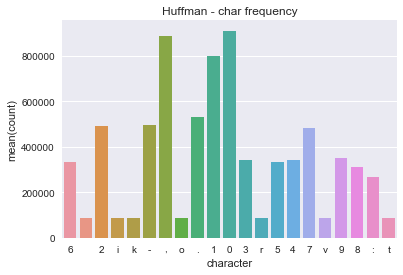

In [227]:
h = Huffman()
h.generate_code(get_file_char_stream(RUN_OR_WALK_REFORMAT_V1_PATH))
h.pprint_code()
count_plot_from_dict(h.get_char_count(), 'character', 'count', 'Huffman - char frequency')
h_1_uc, h_1_c = h.print_compression_info_file(RUN_OR_WALK_REFORMAT_V1_PATH)
h_1_ratio = h_1_c*1. / h_1_uc

Now we try with a different alphabet inputs for the Huffman code , we use the first 10% of the lines (training set) to build the dictionary ,in The plot below present:  
* The size of uncompressed data.  
* **First input alphabet**- we try the "naive" solution and calculate Huffman code for each character.
* **Second input alphabet**- we find the most 5 common values and insert them as one symbol in the calculation of Huffman code.
* **Third input alphabet**- we find the most 10 common values and insert them as one symbol in the calculation of Huffman code.

Replacing  0 Common strings:
Replacing  5 Common strings:


,string,character
0,viktor,""""
1,-0.2856,#
2,-0.1077,$
3,-0.2918,%
4,-0.2376,&


Replacing  10 Common strings:


,string,character
0,viktor,""""
1,-0.2856,#
2,-0.1077,$
3,-0.2918,%
4,-0.2376,&
5,-0.3065,'
6,-0.3344,(
7,-0.2157,)
8,-0.1059,*
9,-0.2782,+


Compression Ratio: [1.0, 0.51, 0.45, 0.45]


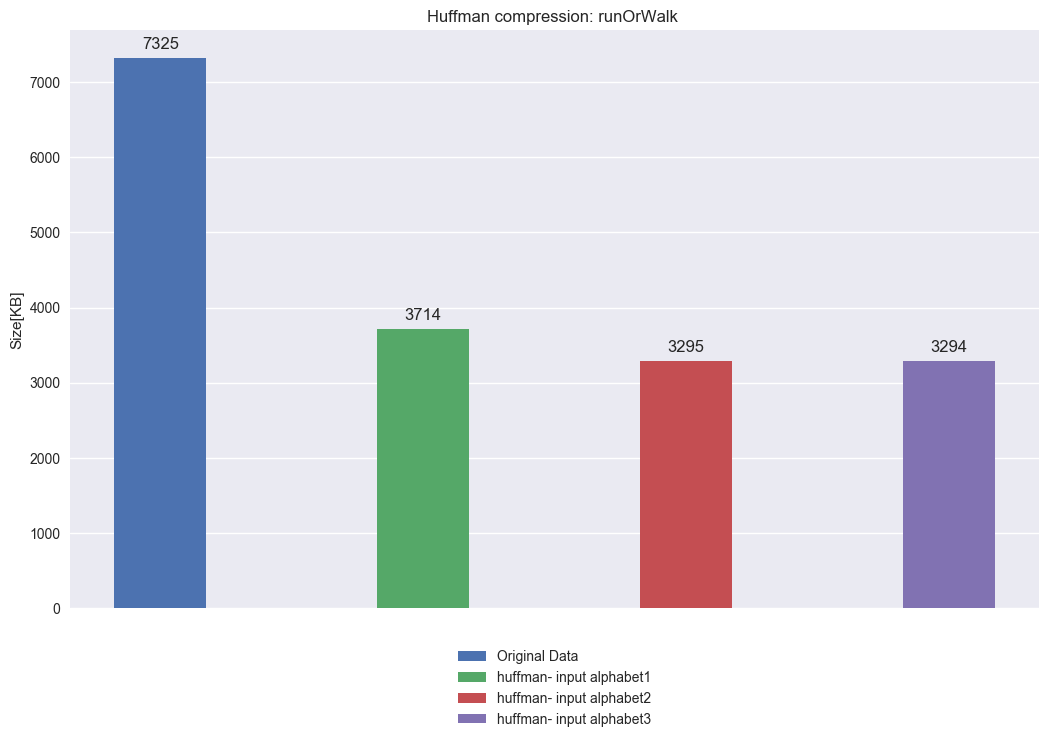

In [2]:
from huffman_ext_func import *
import seaborn as sns
# N1/N2/N3 -conrtol the number of most common symbol(more than 2 character) to use in hufmman code
N1=0
N2=5 
N3=10

data_file=['..\modified_data_sets\\runOrWalk\\runOrWalk_v1.csv']
train_set_file=['..\modified_data_sets\\runOrWalk\\runOrWalk_v1_train_set.dat']
title=['runOrWalk ']

for i in  range (len(data_file)):
    figure_i=i
    huffman_coding_compressed(data_file[i], train_set_file[i],"Huffman compression: " +title[i], figure_i,N1, N2, N3)
plt.show()


As we can see we simple Huffman we get 0.51 ratio but withe replacing 5 most common symbols we get improve of 0.45,
and replacing the 10 most common symbols we get ratio of 0.45 .  
There isn't a lot of improvement between the second and third input because we reduce the number of characters in the data but increase the dictionary base prefix size.  
That show we always need to decide the correct balance between the dictionary size-values.

### Part II-LZ77 
For the second part we used LZ77 that we implement in HW2:
LZ77- algorithms achieve compression by replacing repeated occurrences of data with references to a single copy of that data existing earlier in the uncompressed data stream. A match is encoded by a pair of numbers called a [length,distance]
In this part we need to decide for each data set how we disguise between the pure literal to the [length,distance] pair.  
We try different approaches using LZ77:
#### 1st method-  
we disguise between the pure character and the [length,distance] pair by adding another bit  to each one of them
For example: we added 1 bit for each character and now character represented by 9 bits (instead of 8).
The new mapping is :  
pure character =**[0,char]** ,length-distance pair= **[1,unsingned 8 bit length,1,unsingned 8 bit length]**
In this method we change the values: the bits number of each symbol is 9
and the minimum for length character to copy (3, 5, 7)

#### 2nd method-   
Like the 1st method we add another bit for each character but instead of using the "naive" mapping,
We change the filed sizes of length-distance pair not to be equal to symbol, but for to values that give maximum results. 
Then new mapping: pure character =**[0,char]** ,[length,distance] pair=**[1,unsigned x bits length, y bit offset]** .
now we can also change the tuple size to be y times as the pure literal size
For conclusion in our algorithm we have 3 degrees of freedom:
1) The bits size of the length.
2) The bits size of the offset.
3) The min length character to copy we choose 3,5,7.  
    
for each data set we check possibilities and we represent the best result we get when we use the training set
##### 3rd method-  
We disguise between the pure character and the **[length,distance]** pair by adding special char before the **[length,distance]** pair
The mapping:  
pure character =**char**, length-distance pair=**[special char, unsigned x bits length, unsigned y bit distance]**
In this case we assume that not all 256 characters exist in the data and we can use one character that not appear for the special char.
In this algorithm we have 3  freedom degrees:  
1) The min length character to copy we choose 3, 5, 7.    
2) The maximum character we can copy (unsigned x bits length).  
3) The maximum distance we can use in our history (unsigned y bit distance).
In this method we save pay more overhead in  **[length,distance]** pair compare to the previous method ,but save bit in each data character.  
**Note:** in our code we implement fast mode and slow mode, the difference is the range of values we choose for each freedom degree.  
For each data we learn the optimize parameters for the lz77 algorithm in slow mode  and use it in the fast mode. 


In [5]:
### Parmaters for the runOrWalk Data set

data_file=['..\modified_data_sets\\runOrWalk\\runOrWalk_v1.csv']
train_set_file=['..\modified_data_sets\\runOrWalk\\runOrWalk_v1_train_set.dat']
title=['runOrWalk ']
debug=True  #Debug mode -choose way data compressed is displayed
Fast_mode =True #Don't try all option of bit separation and symbole size
max_seq_bits=[[5,6]] #for fast mode  decide the range values for max_seq bits(length)
window_size_bits_s=[[17,18]]#for fast mode  decide the range values for window_size bits(offset)
window_size_bits_d=[[18,19]]#for fast mode  decide the range values for window_size bits(offset)

In [ ]:
from lz77_ext_func_bit_separation import LZ77_bit_separate
from lz77_ext_func_delimiter import LZ77_delimiter_separate
from my_LZ77 import LZ77

for i in range(len(data_file)):
    figure_i=2*i
    lz77_bit=LZ77_bit_separate(data_file[i],train_set_file[i],"LZ77 Compression (bit separation): "+title[i],Fast_mode,
                               max_seq_bits[i],window_size_bits_s[i],debug)
    lz77_bit.perform_compression_statistics(figure_i)

    lz77_delim=LZ77_delimiter_separate( data_file[i],train_set_file[i],"LZ77 Compression (delimiter separation): "+title[i],
                                        Fast_mode,max_seq_bits[i], window_size_bits_d[i])
    lz77_delim.perform_compression_statistics(figure_i+1)
#plt.show()

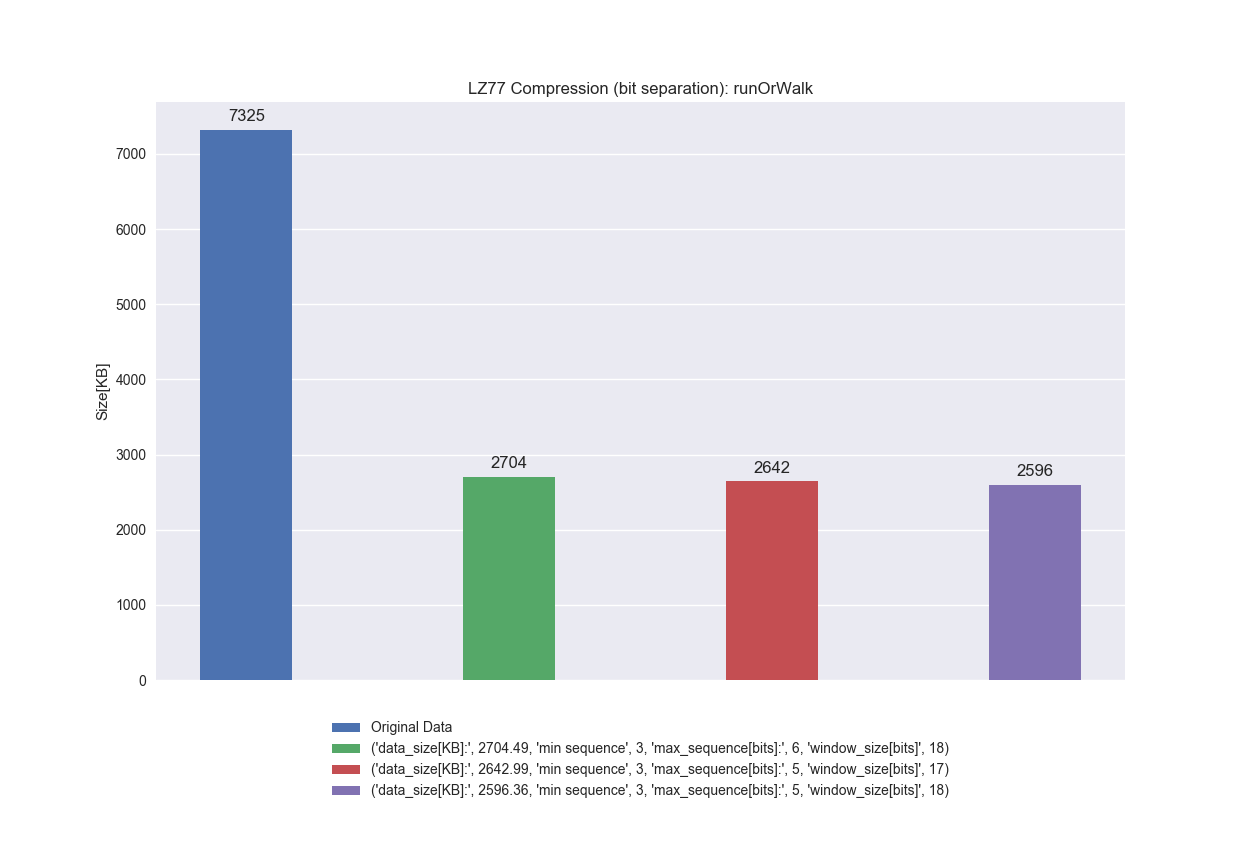
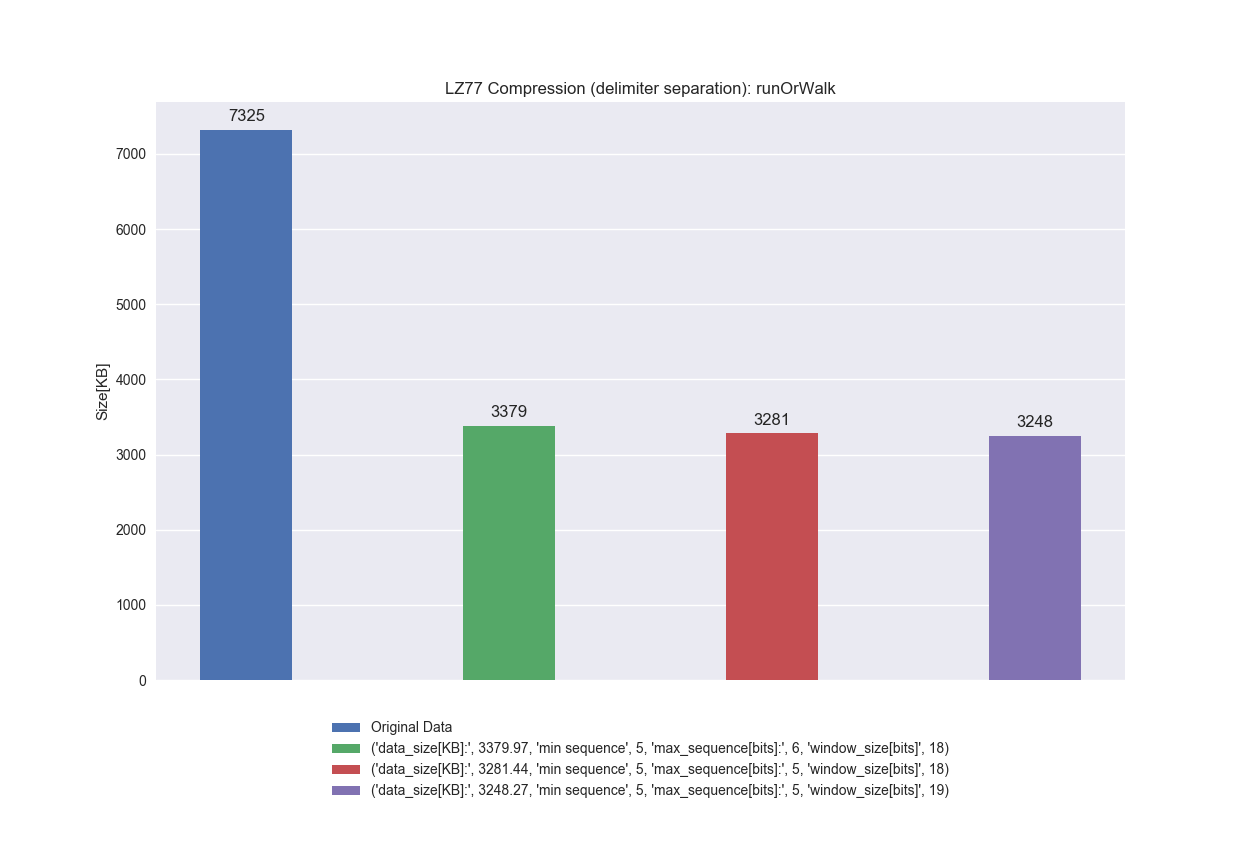

As we can see in case of the second method of **bit separation**:  
We get better Compression Ratio: [1.0, 0.37, 0.36, 0.35]  
The min length character to copy is 3 (the minimum we allow), the max bits to copy is 5(2^5-1+3=34 symbols to copy)  
And we get the best result when the window size is 18 bits(256kb) if we increase we pay in more  the overhead.  
In the 3 method of **delimiter separation**: 
The Compression Ratio: [1.0, 0.46, 0.45, 0.44] 
The min length character to copy is 5, (probably because of the overhead of the special symbol - 8 bits)  
And max sequence bits to copy is 5 (2^5-1 +5=36) , the optimize window size here 19 bits.  
For this data set the second method is better then the third, means we have a lot of short string to copy that the bit separations give batter result.  
Important notice that we didn't consider here the time simulation , for both cases the window size is extremely high 256Kb for bit separation and 512kb to delimiter separation , this window size will harm the performance of the algorithm.

## Part-III

In this part we show 5 ways of improvement to LZ77 and Huffman algorithms, we will try to decrease the output size and compression ratio by the following methods:  
1) **LZ77 and Huffman** - combine the 2 algorithms together like DEFLATE and GZIP.  
2) **LZ77 (separate: data, control,length,offset_high,offset_low) and Huffman** -split the result of the LZ77 to 5 different codes: data, control,length,offset_high,offset_low and perform Huffman on each of one of them.  
3) **Separated columns**- perform Huffman and LZ77 on each columns.  
4) **Clustered Huffman** - compares Huffman using machine learnings technique of clustering. (In the Last Part of the report).   
5) **LZ77 (separate: data, control,length,offset_high,offset_low)** and Clustered Huffman. (In the Last Part of the report).  



### <font color=blue> First method- LZ77 and hufmman </font>
Like GZIP and DEFLATE algorithms we try to combine Lempel-Ziv compression and Huffman coding together,  
as most of the algorithms we prefer to start with LZ77 first and then use Huffman.  
The reason is the big advantage LZ has over Huffman is in treating dependencies between symbols after using LZ77 the symbols are now independent events and ordered randomly, so then Huffman is simpler and works better in that case.

In [ ]:
from huffman_and_lz77_ext_func import LZ77_huffman

for i in range(len(data_file)):
    figure_i=i
    lz77_and_huff_data_control = LZ77_huffman_data_control(data_file[i], train_set_file[i],\
                                "LZ77+Huffman compression (split data control): " + title[i],\
                                 Fast_mode, max_seq_bits[i], window_size_bits_s[i])
    lz77_and_huff_data_control.lz77_and_huffman_compression(figure_i)

#plt.show()

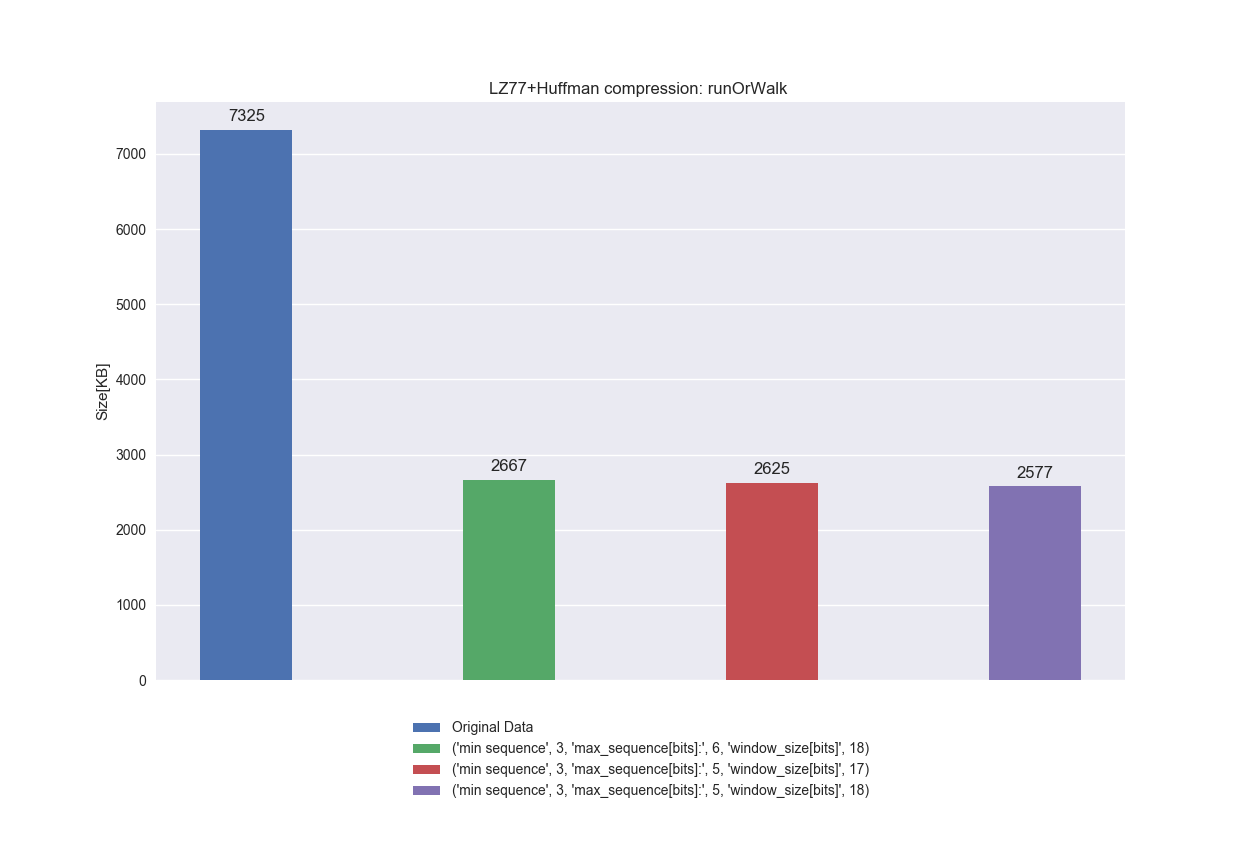

**Compression ratio**=[1.0, 0.36, 0.36, 0.35]  
As we can see we get batter result by combining LZ77 and Huffman from using simple Huffman algorithm or LZ77 algorithm alone.  
But the improvement between using LZ77 alone to LZ77+Huffman is small , the main reason is the way we implement the LZ77 with the bit separation that cause to each character to grow in one bit .  
The Huffman work on Chars(8 bits) so basically we increase a lot of the variance of the data by adding this bit and reduce the effective of the Huffman compression.

### <font color=blue> Second method- LZ77 and Huffman ( separate data ,control,length,offset_high,offset_low)</font>

In the First method we saw that Huffman stage didn't improve a lot the LZ77 algorithms ,  
the reason is the additional bit we add for each character and the Huffman work on every 8 bits(char) so by this method of compressing we increase a lot the variance of the data and harm the effectiveness of Huffman.
Another approach is to split the data ,control,length,offset_high,offset_low to 5 outputs outputs:
* **Data**- we have now char(that will decrease the variance of the data).  
* **Control**- we have '0' or '1'- 0 means pure character and '1' start of [length,distance] pair.  
* **Length**(bit)- maximum sequence to copy.  
* **offset_high **(bit)- maximum window size first 8 higher bits.  
* **offset_low **(bit)- maximum window size lower bits bits.  

Note: we prefer to take th first 8 higher bits instead of the lower 8 bits in that way we guaranty that offset_high will be in 8 bits size and the impact of Huffman compression is higher ,we prefer to used those bits because they variance is much smaller (the possibilities to find a match in the end of the window size-where we start to look is much higher than in the beginning of the window size).   
Now we perform Huffman on each of new outputs separately. 

In [ ]:
from huffman_and_lz77_data_control_ext_func import LZ77_huffman_data_control
min_seq=[4,5,6] # minimum sequnce to copy
max_seq_bits=[[8,8]] #for fast mode  decide the range values for max_seq bits(length)
window_size_bits_s=[[16,16]]#for fast mode  decide the range values for window_size bits(offset)

for i in range(len(data_file)):
    figure_i=i
    lz77_and_huff_data_control = LZ77_huffman_data_control(data_file[i], train_set_file[i],\
                                "LZ77+Huffman compression (split data control): " + title[i],\
                                 Fast_mode, max_seq_bits[i], window_size_bits_s[i],min_seq[i])
    lz77_and_huff_data_control.lz77_and_huffman_compression(figure_i)

#plt.show()

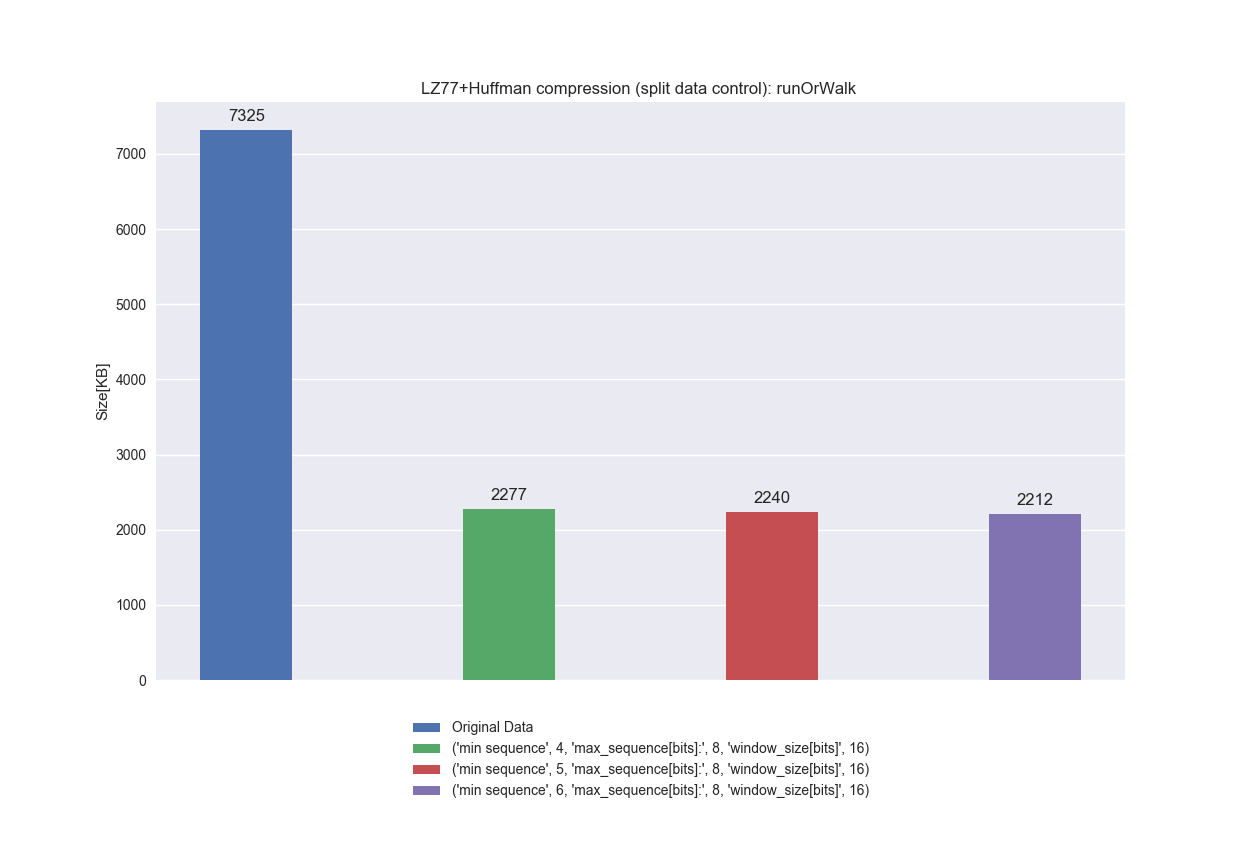

*Compression Ratio*: [1.0, 0.31, 0.31, 0.3].  
Now after we split the data ,control,offset_high,offset_low,length we can  that the Huffman compression in the second phase give batter results.  
The most interesting part here that the best results  we get(after checking variance of inputs in slow mode option) is for window_size=16[bit] (64 KB) and max_sequence=8[bit] ,  
the reason again is the Huffman work on char(8 bits) and for this parameters we get that Huffman is the most effective on windows_size and max_sequence.  
Another interesting point in that case the that we prefer to increase the min sequence by this we prefer to decrease the variation of the Huffman and expense saving bits by replacing it  with a pointer.  
Also we get improvement in time simulation because decreasing the windows size bits, and parallelize the Huffman compression.  
The main conclusions for this part:  
The best compression result can't be done by using greedy algorithm in LZ77, Instead we need to get the best compression that keep small variance with size bits that divide by char(8 bits) so the Huffman will be more effective.  
WE need to find the compression balance between LZ77 to Huffman.


### <font color=blue> Third method-Separation column</font>
Another try is to use the algorithm compression for each column.
In this case the variance of the data should be much smaller and the effective of both algorithms will be grater, this way of compression should improve our compression ratio.  
In this section we had another parameter (equal) to set if we use separate only by columns or separate by any other delimiter we find in the data (this mode is less effective when the columns is not equals)

In [ ]:
from separate_column_ext_func import *

equal=True
for i in range (len(data_file)):
    figure_i=i
    compress = separate_columns_compress(data_file[i], train_set_file[i], "LZ77+Huffman compression (split columns): " + title[i],
                                    Fast_mode, max_seq_bits[i], window_size_bits_s[i],debug,equal[i])
    compress.separate_columns_compression(figure_i)
#plt.show()

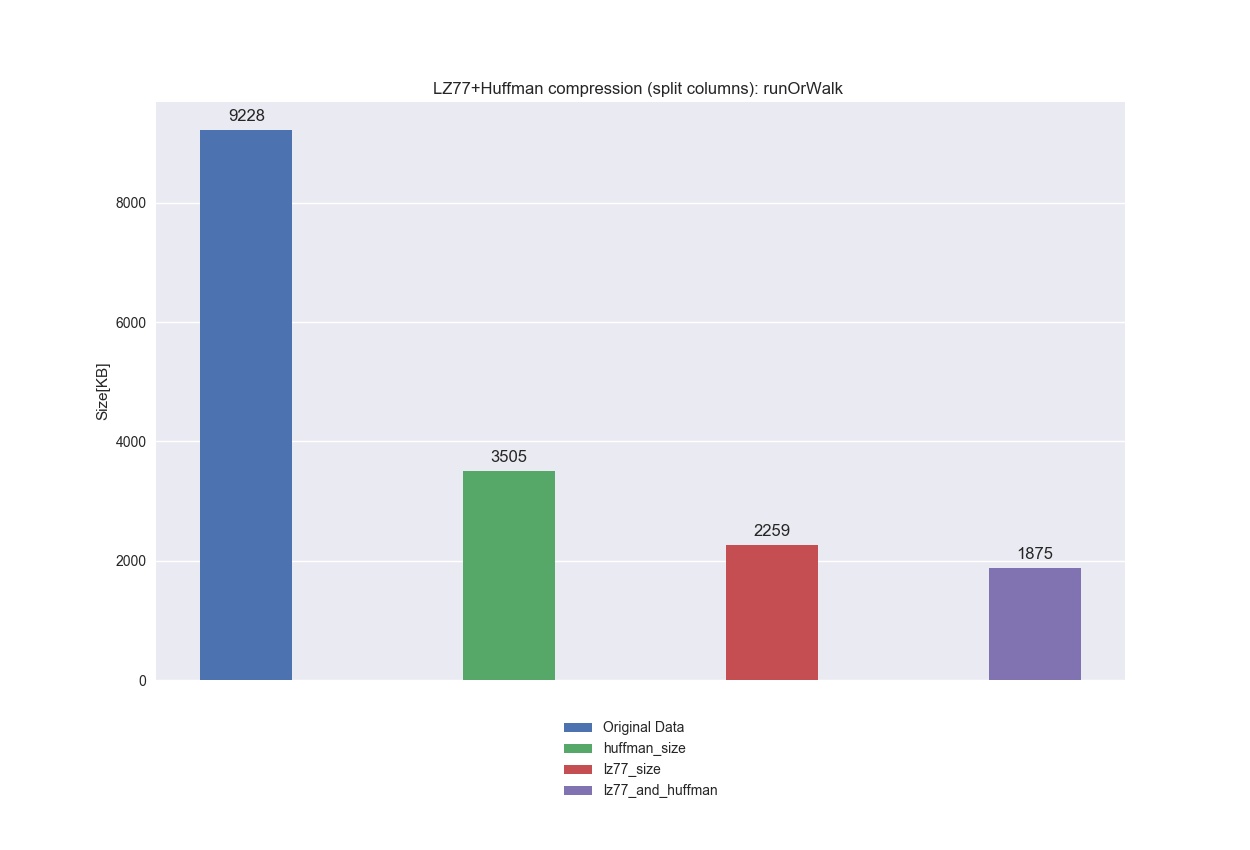

As we expected by separate to column the variance of each column of data is smaller and also the compression ratio  comparing using all data and we get much better result:  
**Huffman**- compression_ratio= 0.38 compare to compression_ratio=0.45 in case of compressing all data.  
**LZ77** - compression_ratio= 0.24 compare to compression_ratio=0.35 in case of compressing all data.  
**LZ77 and Huffman** - compression_ratio= 0.2 compare to compression_ratio=0.33 in case of compressing all data.
Also the simulation run-time for this case can significantly improve if we using parallel computing ,  
the disadvantage for this is that the data should be in fixed template (that every sample have the same field).   

### <font color=blue> Fourth method -Clustered Huffman</font>
The last part of the report.

### <font color=blue> Fifth method-  LZ77 (separate data, control) and Clustered Huffman</font>
The last part of the report.

## Data set 2 - Mobile location history of 10/2014 
#### History of Locations of an android mobile in the month of October 2014.
https://www.kaggle.com/juliansimon/location-history

The dataset provided in json format and isn't tabular, means there are records that contains different numbers of fiels and lists. file size is 6149910 bytes (5.9M)

Examples:
1. 
   {                                                                                                                                                                      
     "timestampMs" : "1415045775364",                                                                                                                                        
     "latitudeE7" : 404213246,                                                                                                                                               
     "longitudeE7" : -36285327,                                                                                                                                              
     "accuracy" : 36                                                                                                                                                         
   }
2. {                                                                                                                                                                      
     "timestampMs" : "1415045715276",                                                                                                                                        
     "latitudeE7" : 404213284,                                                                                                                                               
     "longitudeE7" : -36285262,                                                                                                                                              
     "accuracy" : 36,                                                                                                                                                        
     "activitys" : [ {                                                                                                                                                       
       "timestampMs" : "1415045702461",                                                                                                                                      
       "activities" : [ {                                                                                                                                                    
         "type" : "unknown",                                                                                                                                                 
         "confidence" : 68                                                                                                                                                   
       }, {                                                                                                                                                                  
         "type" : "onBicycle",                                                                                                                                               
         "confidence" : 19                                                                                                                                                   
       }, {                                                                                                                                                                  
         "type" : "inVehicle",                                                                                                                                               
         "confidence" : 8                                                                                                                                                    
       }, {                                                                                                                                                                  
         "type" : "still",                                                                                                                                                   
         "confidence" : 6                                                                                                                                                    
       } ]                                                                                                                                                                   
     } ] 
    }

This format provides some hardness in reducing footprint by structure, because it isn't deterministic we can't just drop the key names (and some of the enumerated value names).  
However json format contains a lot of non semantic information spaces and line breaks suppose to make the data set easier to read by human beings. 
Before applying any fancy compression we can easily reduce data set size by give up the human readability and trim all the fluffy characters. 
reading the data set and dump it again with python json package reduce the file size from 6149910 Bytes to 4865853 Bytes (0.79%), it becoming a one big line looking like that:
....{"latitudeE7": 404212492, "accuracy": 26, "longitudeE7": -36286189, "timestampMs": "1412114163888"}, {"latitudeE7": 404212787, "accuracy": 21, "longitudeE7": -36285734, "timestampMs": "1412114103956"}....

but the default dump still pad spaces after ':' and ',', so we can do better by drop it too (code below) that output data set file sized 4476978 Bytes (0.72%)

In [208]:
MOBILE_LOCATION_HISTORY_PATH = '../data_sets/mobileLocationHistory102014/location_history_102014.json'
MOBILE_LOCATION_HISTORY_REFORMAT_V1_PATH = '../modified_data_sets/mobileLocationHistory102014/location_history_102014_v1.json'

import json
if not os.path.isfile(MOBILE_LOCATION_HISTORY_REFORMAT_V1_PATH):
    with open(MOBILE_LOCATION_HISTORY_PATH, 'r') as fr:
        raw = json.loads(fr.read())
    with open(MOBILE_LOCATION_HISTORY_REFORMAT_V1_PATH, 'w') as outfile:
        json.dump(raw, outfile, separators=(',', ':'))


### Part 1 - Huffman Coding
Let's construct the Huffman Code, calculate the compressed size and plot the char count:

,uncompressed,compressed(without code),dictionary,ratio(without code),total ratio
0,35815824,21947999,1025,0.612802,0.61283


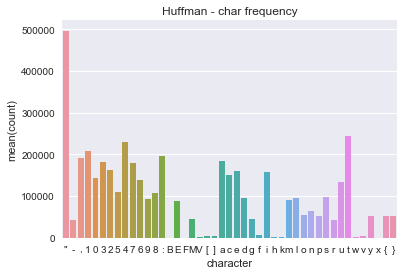

In [209]:
h = Huffman()
h.generate_code(get_file_char_stream(MOBILE_LOCATION_HISTORY_REFORMAT_V1_PATH))
h_2_uc, h_2_c = h.print_compression_info_file(MOBILE_LOCATION_HISTORY_REFORMAT_V1_PATH)
h_2_ratio = h_2_c*1. / h_2_uc
count_plot_from_dict(h.get_char_count(), 'character', 'count', 'Huffman - char frequency')

One of the json format objectives is to be easy to read by human beings. but the cost is a lot of break line characters and space characters, as can be seen from the character count plot.

now we try with a different alphabet inputs for the Huffman code , we use the first 10% of the lines (training set) to build the dictionary ,in The plot below present:  
* The size of uncompressed data  
* **First input alphabet**- we try the "naive" solution and calculate Huffman code for each character
* **Second input alphabet**- we find the most 5 common values and insert them as one symbol in the calculation of Huffman code
* **Third input alphabet**- we find the most 10 common values and insert them as one symbol in the calculation of Huffman code

Replacing  0 Common strings:
Replacing  5 Common strings:


,string,character
0,"""longitudeE7"":-59490150",""""
1,"""accuracy"":2991",#
2,"{""latitudeE7"":401158154",$
3,"""accuracy"":34",%
4,"""longitudeE7"":-58308510",&


Replacing  10 Common strings:


,string,character
0,"""longitudeE7"":-59490150",""""
1,"""accuracy"":2991",#
2,"{""latitudeE7"":401158154",$
3,"""accuracy"":34",%
4,"""longitudeE7"":-58308510",&
5,"""accuracy"":2894",'
6,"""accuracy"":3}",(
7,"""type"":""unknown""}",)
8,"{""latitudeE7"":401776136",*
9,"""type"":""inVehicle""}",+


Compression Ratio: [1.0, 0.61, 0.61, 0.6]


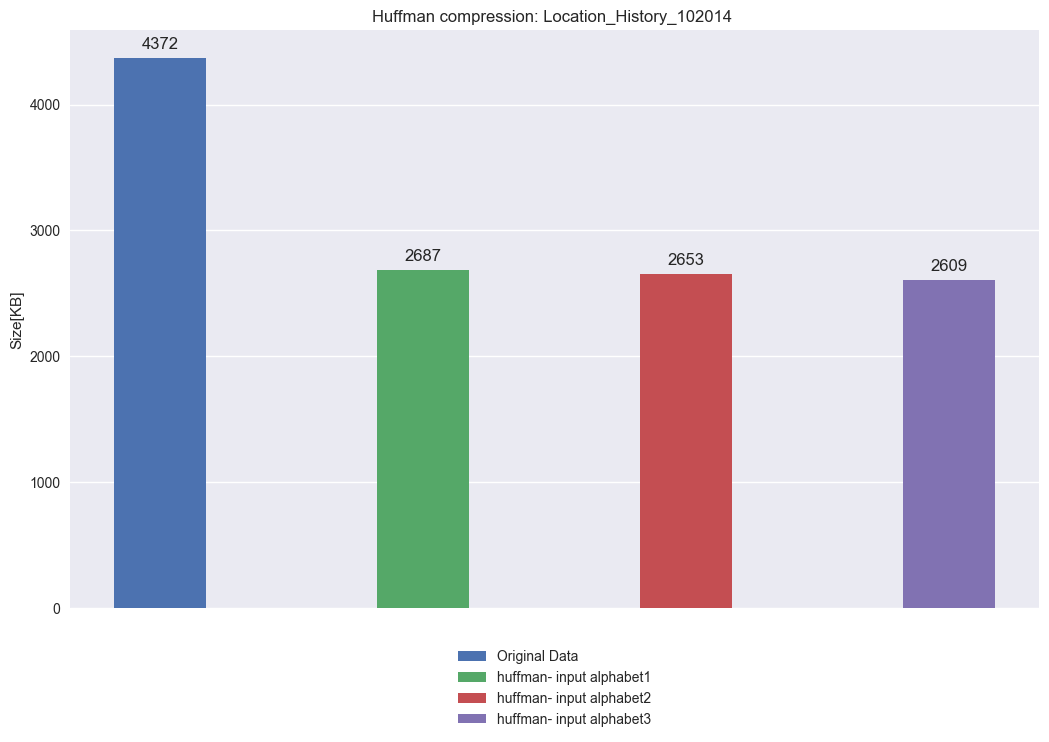

In [ ]:
from huffman_ext_func import *
# N1/N2/N3 -conrtol the number of most common symbol(more than 2 character) to use in hufmman code
N1=0
N2=5 
N3=10

data_file=['..\modified_data_sets\mobileLocationHistory102014\location_history_102014_v1.json']
train_set_file=['..\modified_data_sets\mobileLocationHistory102014\location_history_102014_v1_train_set.dat']
title=['Location_History_102014 ']

for i in  range (len(data_file)):
    figure_i=i
    huffman_coding_compressed(data_file[i], train_set_file[i],"Huffman compression: " +title[i], figure_i,N1, N2, N3)
plt.show()


As we can see we simple Huffman we get 0.61 ratio , replacing 5 common symbols we get a little improve,  
and replacing the 10 most common symbols we get ratio of 0.6.  
Again For this data set the replacing of some string with other char character didn't help because of the high variance of the data and  reducing the number of characters in the data can increase the dictionary base prefix size.  

#### Part II-LZ77
The bit separation method and chracter separation method

In [4]:
### Parmaters for the mobileLocationHistory102014 Data set

data_file=['..\modified_data_sets\mobileLocationHistory102014\location_history_102014_v1.json']
train_set_file=['..\modified_data_sets\mobileLocationHistory102014\location_history_102014_v1_train_set.dat']
title=['Location_History_102014 ']
debug=True  #Debug mode -choose way data compressed is displayed
Fast_mode =True #Don't try all option of bit separation and symbole size
max_seq_bits=[[5,6]] #for fast mode  decide the range values for max_seq bits(length)
window_size_bits_s=[[17,18]]#for fast mode  decide the range values for window_size bits(offset)
window_size_bits_d=[[18,19]]#for fast mode  decide the range values for window_size bits(offset)

In [ ]:
from lz77_ext_func_bit_separation import LZ77_bit_separate
from lz77_ext_func_delimiter import LZ77_delimiter_separate
from my_LZ77 import LZ77

for i in range(len(data_file)):
    figure_i=2*i
    lz77_bit=LZ77_bit_separate(data_file[i],train_set_file[i],"LZ77 Compression (bit separation): "+title[i],Fast_mode,
                               max_seq_bits[i],window_size_bits_s[i],debug)
    lz77_bit.perform_compression_statistics(figure_i)

    lz77_delim=LZ77_delimiter_separate( data_file[i],train_set_file[i],"LZ77 Compression (delimiter separation): "+title[i],
                                        Fast_mode,max_seq_bits[i], window_size_bits_d[i])
    lz77_delim.perform_compression_statistics(figure_i+1)
#plt.show()

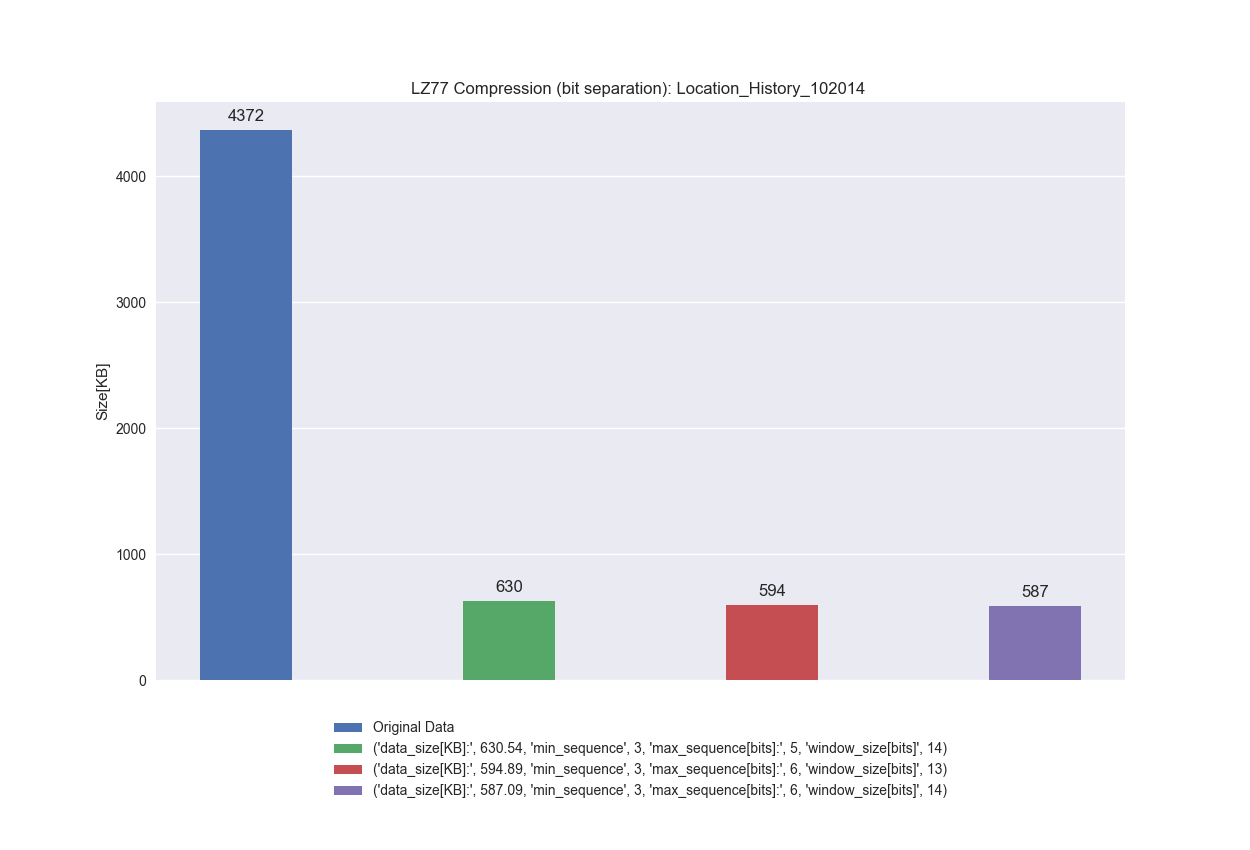
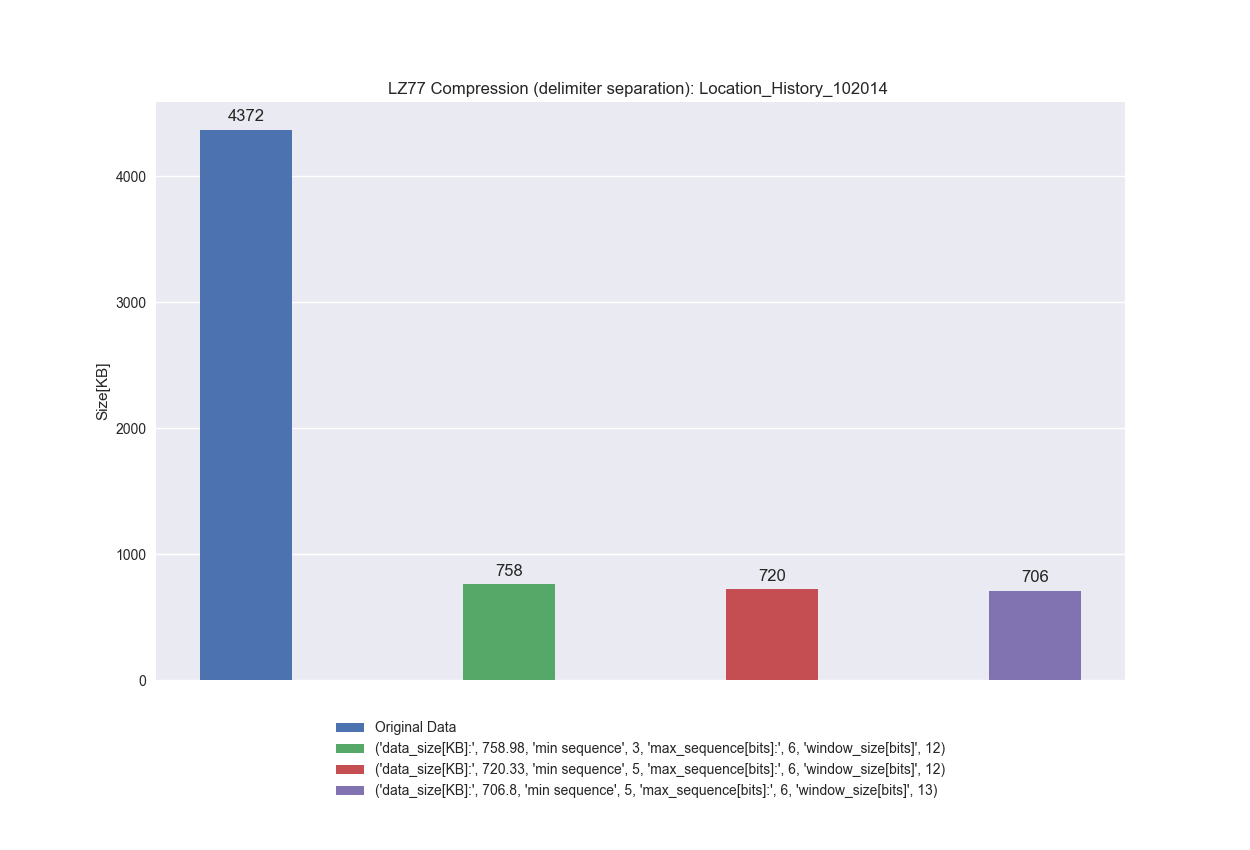

As we can see in case of the second method of **bit separation**:  
We get the best **Compression Ratio**: [1.0, 0.15, 0.14, 0.13]     
The min length character to copy is 3 (the minimum we allow) , the max bits to copy is 6(2^6+3=67 symbols to copy) 
and we get the best result when the window size is 14 bits[16 KB]  if we increase it we pay a lot for the overhead.  
In the 3 method of **delimiter separation** : [1.0, 0.175, 0.17, 0.166]   
The min length character to copy is 5,(probably because of the overhead of the special symbol - 8 bits)
And max sequence bit to copy is 6 (2^6+5=68) so it mean that we prefer in this data set to have a greater history on expense of character to copy.   
Also for this data set the bit separation is better , means we have a lot of short sequence to copy that the bit separations give batter result.

## Part-III

In this part we show 5 ways of improvement to LZ77 and Huffman algorithms, we will try to decrease the output size and compression ratio by the following methods:  
1) **LZ77 and Huffman** - combine the 2 algorithms together like DEFLATE and GZIP.  
2) **LZ77 (separate: data, control,length,offset_high,offset_low) and Huffman** -split the result of the LZ77 to 5 different codes: data, control,length,offset_high,offset_low and perform Huffman on each of one of them.  
3) **Separated columns**- perform Huffman and LZ77 on each columns.  
4) **Clustered Huffman** - compares Huffman using machine learnings technique of clustering. (In the Last Part of the report).   
5) **LZ77 (separate: data, control,length,offset_high,offset_low)** and Clustered Huffman. (In the Last Part of the report). 


### <font color=blue> First method- LZ77 and hufmman </font>
Like GZIP and DEFLATE algorithms we try to combine Lempel-Ziv compression and Huffman coding together. 

In [ ]:
from huffman_and_lz77_ext_func import LZ77_huffman

for i in range(len(data_file)):
    figure_i=i
    lz77_and_huff_data_control = LZ77_huffman_data_control(data_file[i], train_set_file[i],\
                                "LZ77+Huffman compression (split data control): " + title[i],\
                                 Fast_mode, max_seq_bits[i], window_size_bits_s[i])
    lz77_and_huff_data_control.lz77_and_huffman_compression(figure_i)

#plt.show()

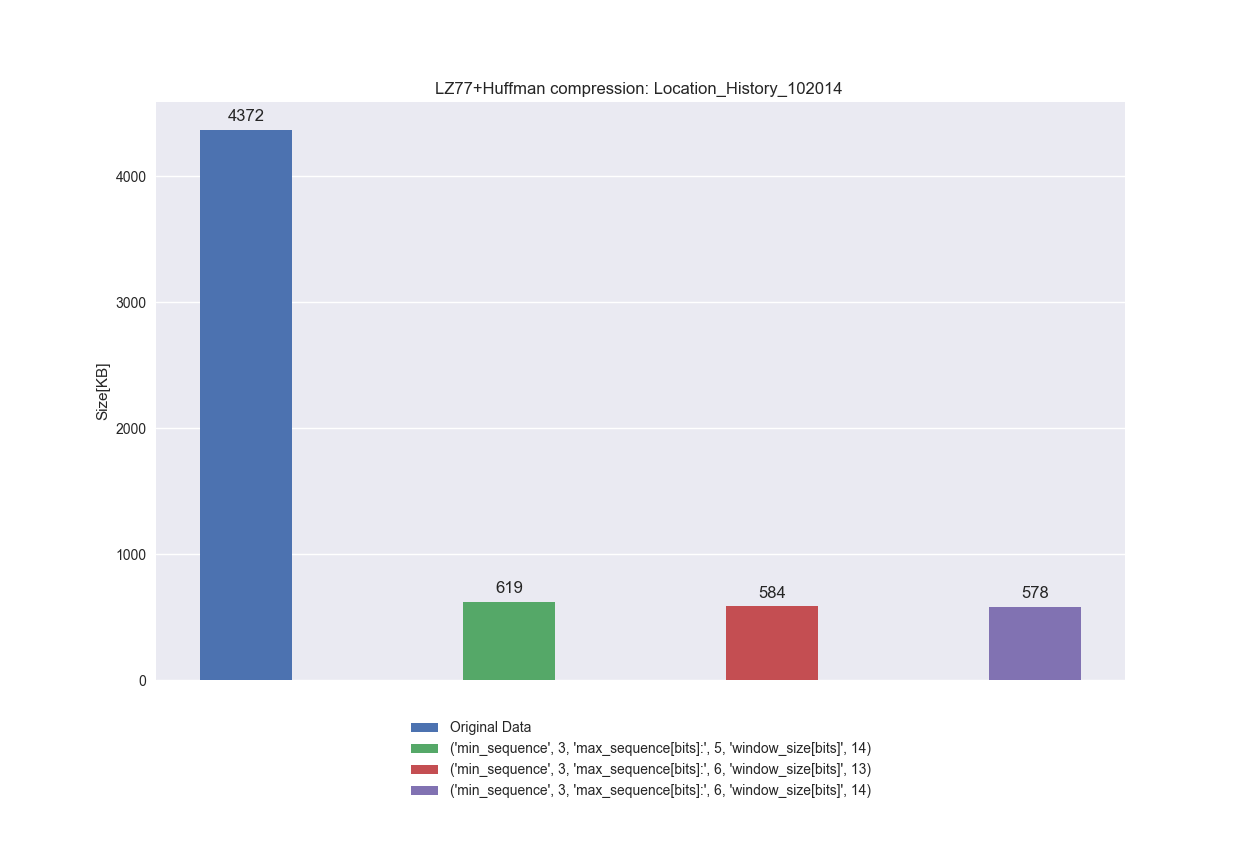

As we can see we get batter result by combining LZ77 and Huffman from using simple Huffman algorithm or LZ77 algorithm alone.  
Compression Ratio=0.13.  
But also in this case we can we can improve the compression, the main reason is the way we implement the LZ77 with the bit separation that cause to each character to grow in one bit .  
The Huffman work per char so basically we increase the variance of the data by adding this bit and reduce the effective of the Huffman compression.

### <font color=blue> Second method- LZ77 and Huffman ( separate data ,control,length,offset_high,offset_low)</font>

In the First method we saw that Huffman stage didn't improve a lot the LZ77 algorithms ,  
the reason is the additional bit we add for each character and the Huffman work on every 8 bits(char) so by this method of compressing we increase a lot the variance of the data and harm the effectiveness of Huffman.
Another approach is to split the data ,control,length,offset_high,offset_low to 5 outputs outputs:
* **Data**- we have now char(that will decrease the variance of the data).  
* **Control**- we have '0' or '1'- 0 means pure character and '1' start of [length,distance] pair.  
* **Length**(bit)- maximum sequence to copy.  
* **offset_high **(bit)- maximum window size first 8 higher bits.  
* **offset_low **(bit)- maximum window size lower bits bits.  

In [ ]:
from huffman_and_lz77_data_control_ext_func import LZ77_huffman_data_control
min_seq=[4,5,6] # minimum sequnce to copy
max_seq_bits=[[8,8]] #for fast mode  decide the range values for max_seq bits(length)
window_size_bits_s=[[8,8]]#for fast mode  decide the range values for window_size bits(offset)
for i in range(len(data_file)):
    figure_i=i
    lz77_and_huff_data_control = LZ77_huffman_data_control(data_file[i], train_set_file[i],\
                                "LZ77+Huffman compression (split data control): " + title[i],\
                                 Fast_mode, max_seq_bits[i], window_size_bits_s[i],min_seq[i])
    lz77_and_huff_data_control.lz77_and_huffman_compression(figure_i)

#plt.show()

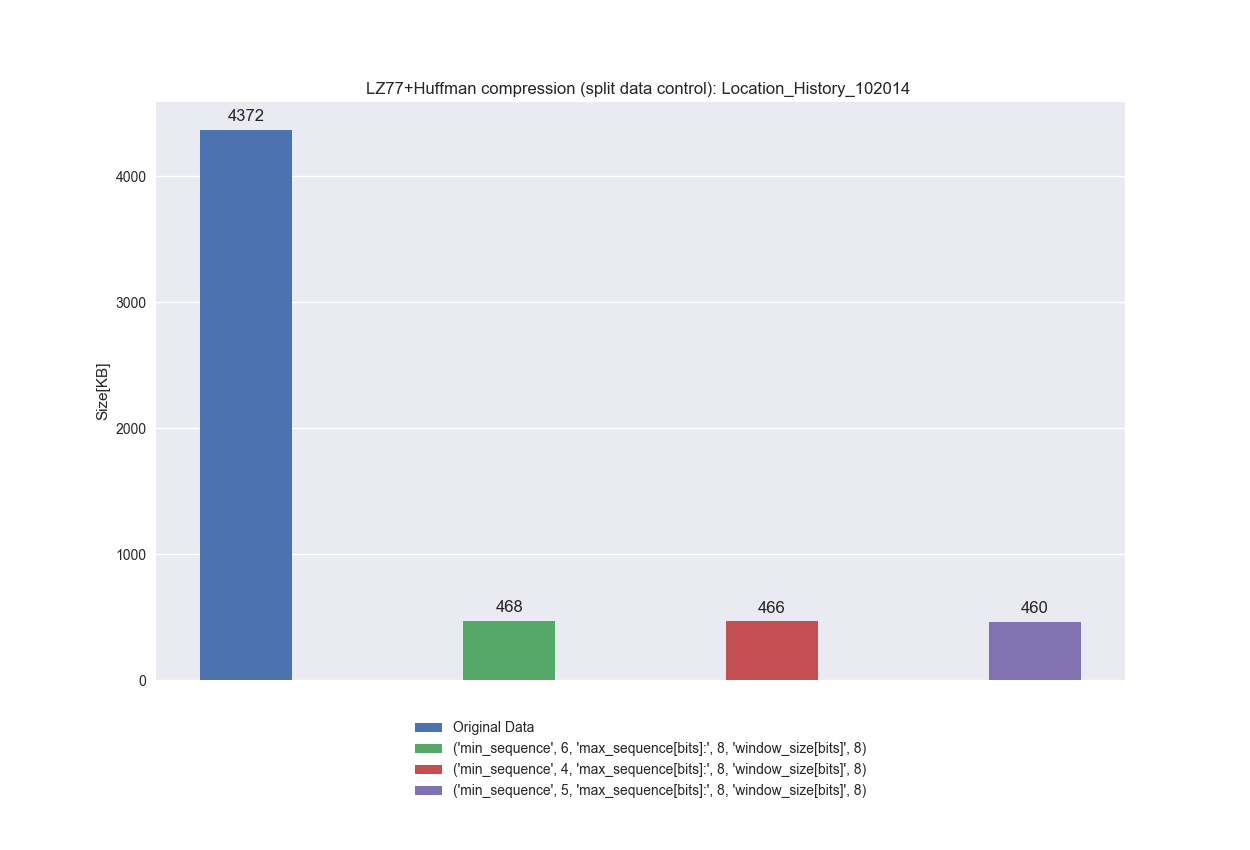

**Compression Ratio**: [1.0, 0.11, 0.11, 0.1].  
Now after we split the data ,control,offset_high,offset_low,length we can  that the Huffman compression in the second phase give batter results.  
Also here the best results we get(after checking variance of inputs in slow mode option) is for window_size=8[bit] (256B) and max_sequence=8[bit] ,  
the reason again is the Huffman work on char(8 bits) and for this parameters we get that Huffman is the most effective on windows_size and max_sequence.  
In this case we see again that we prefer to not maximize the LZ77 compression for getting the best result Instead we need to get the best compression that keep small variance with size bits that divide by char(8 bits) so the Huffman will be more effective. 
Also we get improvement in time simulation because decreasing the windows size bits, and parallelize the Huffman compression.  
In  we get the same conclusion like the last part that we need to find the compression balance between LZ77 to Huffman.


### <font color=blue> Third method-Separation column</font>
Another try is to use the algorithm compression for each column.  
The json file have different fields and if we transform the data to columns we get that each part have not equal columns. 
(some time-stamp for example have not just longitude and latitude but also accuracy).
For this part we change our data we use and we put the json into columns to fit the algorithm .  
In this case now the reference of the original data size=1728[KB]

In [ ]:
from separate_column_ext_func import separate_columns_compress
#################################
### main
#################################
data_file=['..\modified_data_sets\mobileLocationHistory102014\location_history_102014_v1.json']
train_set_file=['..\modified_data_sets\mobileLocationHistory102014\location_history_102014_v1_train_set.dat']
equal=[False] #equal columns

for i in range (len(data_file)):
    figure_i=i
    compress = separate_columns_compress(data_file[i], train_set_file[i], "LZ77+Huffman compression (split columns): " + title[i],
                                    Fast_mode, max_seq_bits[i], window_size_bits_s[i],debug,equal[i])
    compress.separate_columns_compression(figure_i)
#plt.show()

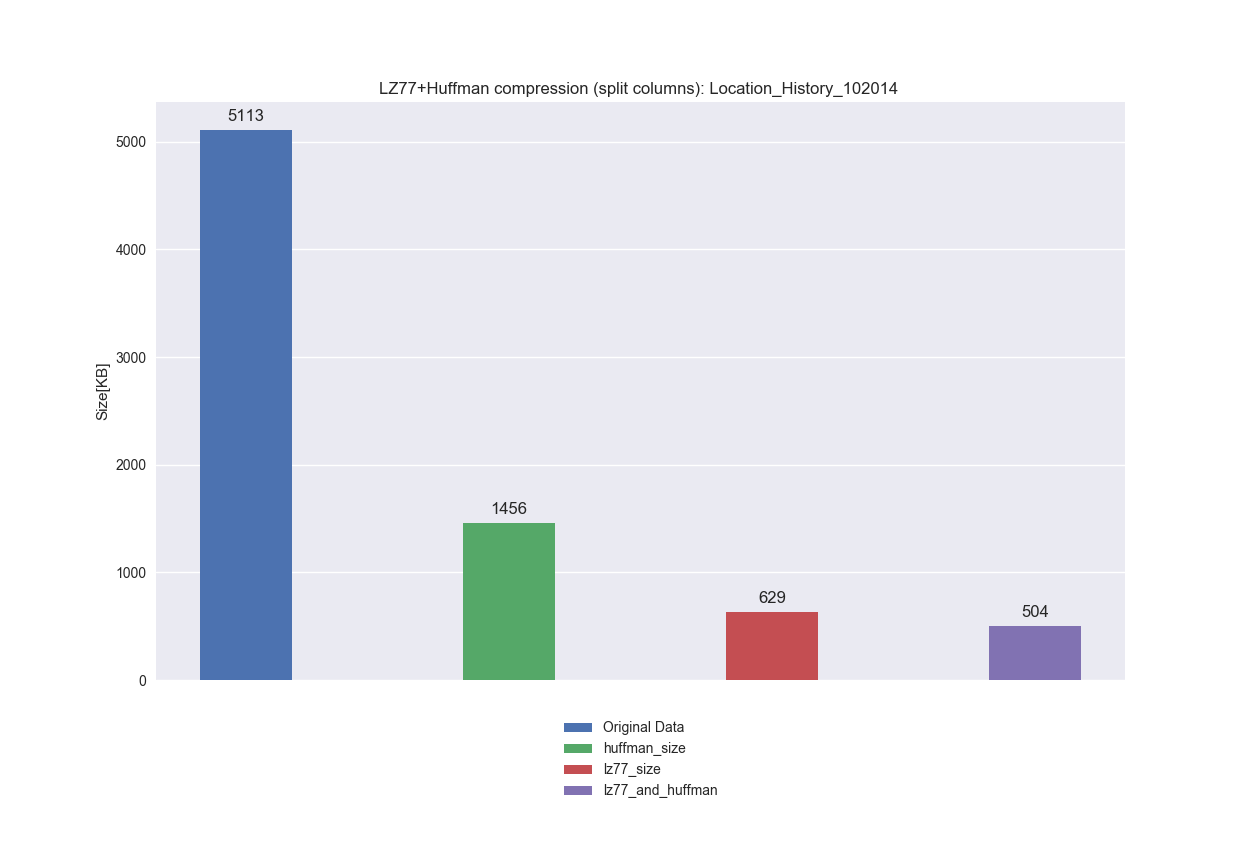

In this case the separation columns didn't improve the compression ratio, it even harm it. (the original data is 1728[KB] but after reshape it to columns it  increase to 5113[Kb])
As we can see by using this method we almost tripled the data size of the original  (because we need to place every element in the columns if it was empty we replace it with a comma).  
We can see that some columns that in the beginning didn't include more than 20 bytes (contain small really smal data)  
but with this method they increased to to 20KB.  
Compression ratio of all data:  
**Huffman** - compression ratio= 0.83 compare to compression ratio=0.6 in case of compressing all data.  
**LZ77** - compression ratio= 0.35 compare to compression ratio=0.12 in case of compressing all data.  
**LZ77 and Huffman** - compression ratio= 0.32 compare to compression ratio=0.1 in case of compressing all data.  
For conclusion it is batter not to use this method for Json data.

### <font color=blue> Fourth method -Clustered Huffman</font>
The last part of the report.

### <font color=blue> Fifth method-  LZ77 (separate data, control) and Clustered Huffman</font>
The last part of the report.

## Data set 3 - 2016 NYC Real Time Traffic Speed Data Feed  
The data contains 'real-time' traffic information from locations where NYCDOT picks up sensor feeds within the five boroughs of NYC, mostly on major arterials and highways. The data includes some meta fields such id, status, date and link id and the sensored data speed/travel time.

We works on april 2016 data set, which contains 1141384 records in csv format. Total size is 62972355 [Bytes] (60M).

Let's load the data and see the header and few lines. Also, as done in data set 1, we will remove the header line and '\r' character.

In [210]:
NYC_PATH = '../data_sets/nyc2016/april2016.csv'
NYC_REFORMAT_V1_PATH = '../modified_data_sets/nyc2016/april2016_v1.csv'

if not os.path.isfile(NYC_REFORMAT_V1_PATH):
    fw = open(NYC_REFORMAT_V1_PATH,'w')
    with open(NYC_PATH,'r') as fr:
        fr.readline()
        for l in fr.readlines():
            fw.write(l.replace('\r',''))
    fw.close()

df = pd.read_csv(NYC_PATH)
df.head()



,Id,Speed,TravelTime,Status,DataAsOf,linkId
0,169,57.17,162,0,4/1/2016 00:05:50,4616355
1,170,55.92,67,0,4/1/2016 00:05:50,4616356
2,171,14.91,807,0,4/1/2016 00:05:50,4616357
3,172,54.06,79,0,4/1/2016 00:05:50,4616310
4,177,54.06,80,0,4/1/2016 00:05:50,4616309


### Part 1 - Huffman Coding  

We will construct the Huffman Code, and calculate the compressed size. As the RunOrWalk data set it contains duplicate end EOL \r\n so we removing them.  
From looking on the char count we can see high frequency of the '"' character. reviewing the data set showing a lot of reserved quatation which wrap each cell number, In chapter 3 we will remove it.

,uncompressed,compressed(without code),dictionary,ratio(without code),total ratio
0,494647328,230919627,350,0.466837,0.466838


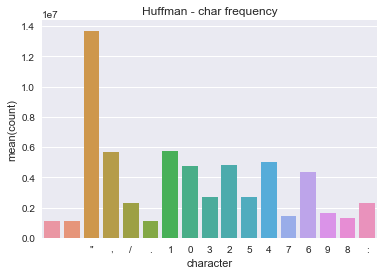

In [211]:
h = Huffman()
h.generate_code(get_file_char_stream(NYC_REFORMAT_V1_PATH))
h_3_uc, h_3_c = h.print_compression_info_file(NYC_REFORMAT_V1_PATH)
h_3_ratio = h_3_c*1. / h_3_uc
count_plot_from_dict(h.get_char_count(), 'character', 'count', 'Huffman - char frequency')

now we try with a diffErent alphabet inputs for the Huffman code , we use the first 10% of the lines (training set) to build the dictionary ,in The plot below present:  
* The size of uncompressed data  
* **First input alphabet**- we try the "naive" solution and calculate Huffman code for each character.
* **Second input alphabet**- we find the most 5 common values and insert them as one symbol in the calculation of Huffman code.
* **Third input alphabet**- we find the most 10 common values and insert them as one symbol in the calculation of Huffman code.

Replacing  0 Common strings:
Replacing  5 Common strings:


,string,character
0,4/2/2016 18:50:51,""""
1,52.2,#
2,54.06,$
3,57.17,%
4,52.82,&


Replacing  10 Common strings:


,string,character
0,4/2/2016 18:50:51,""""
1,52.2,#
2,54.06,$
3,57.17,%
4,52.82,&
5,50.95,'
6,49.71,(
7,55.3,)
8,49.09,*
9,4/2/2016 18:50:53,+


Compression Ratio: [1.0, 0.48, 0.47, 0.47]


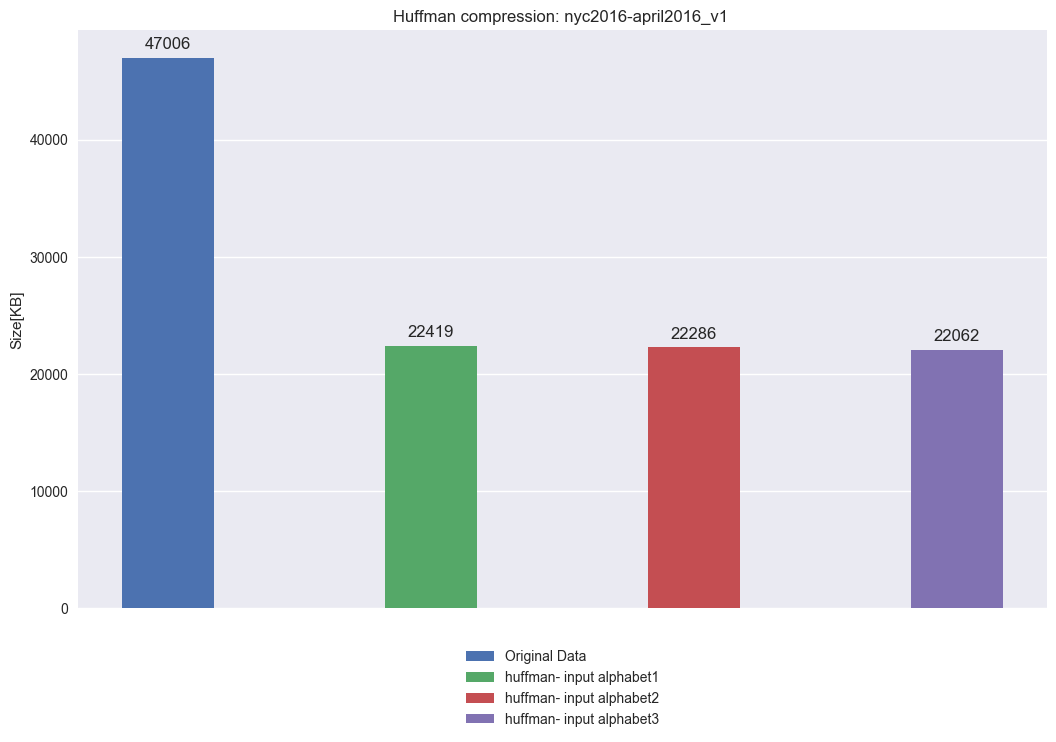

In [4]:
from huffman_ext_func import *
# N1/N2/N3 -conrtol the number of most common symbol(more than 2 character) to use in hufmman code
N1=0
N2=5 
N3=10

data_file=['..\modified_data_sets\\nyc2016\\april2016_v1.csv']
train_set_file=['..\modified_data_sets\\nyc2016\\april2016_v1_train_set.dat']
title=['nyc2016-april2016_v1 ']

for i in  range (len(data_file)):
    figure_i=i
    huffman_coding_compressed(data_file[i], train_set_file[i],"Huffman compression: " +title[i], figure_i,N1, N2, N3)
plt.show()


As we can see in simple Huffman we get 0.48 ratio but withe replacing 5 common symbols we get improve of 0.47 ,
and replacing the 10 most common symbols we get smaller improve compression ratio of 0.469.  
Again There isn't a lot of improvement between the second and third input because we reduce the number of characters in the data but increase the dictionary base prefix size.  

#### Part II-LZ77
The bit separation method and chracter separation method

In [ ]:
### Parmaters for the runOrWalk Data set
data_file=['..\modified_data_sets\\nyc2016\\april2016_v1.csv']
train_set_file=['..\modified_data_sets\\nyc2016\\april2016_v1_train_set.dat']
title=['nyc2016-april2016_v1 ']
debug=True  #Debug mode -choose way data compressed is displayed
Fast_mode =True #Don't try all option of bit separation and symbole size
max_seq_bits=[[5,6]] #for fast mode  decide the range values for max_seq bits(length)
window_size_bits_s=[[17,18]]#for fast mode  decide the range values for window_size bits(offset)
window_size_bits_d=[[18,19]]#for fast mode  decide the range values for window_size bits(offset)

In [ ]:
from lz77_ext_func_bit_separation import LZ77_bit_separate
from lz77_ext_func_delimiter import LZ77_delimiter_separate
from my_LZ77 import LZ77

for i in range(len(data_file)):
    figure_i=2*i
    lz77_bit=LZ77_bit_separate(data_file[i],train_set_file[i],"LZ77 Compression (bit separation): "+title[i],Fast_mode,
                               max_seq_bits[i],window_size_bits_s[i],debug)
    lz77_bit.perform_compression_statistics(figure_i)

    lz77_delim=LZ77_delimiter_separate( data_file[i],train_set_file[i],"LZ77 Compression (delimiter separation): "+title[i],
                                        Fast_mode,max_seq_bits[i], window_size_bits_d[i])
    lz77_delim.perform_compression_statistics(figure_i+1)
#plt.show()

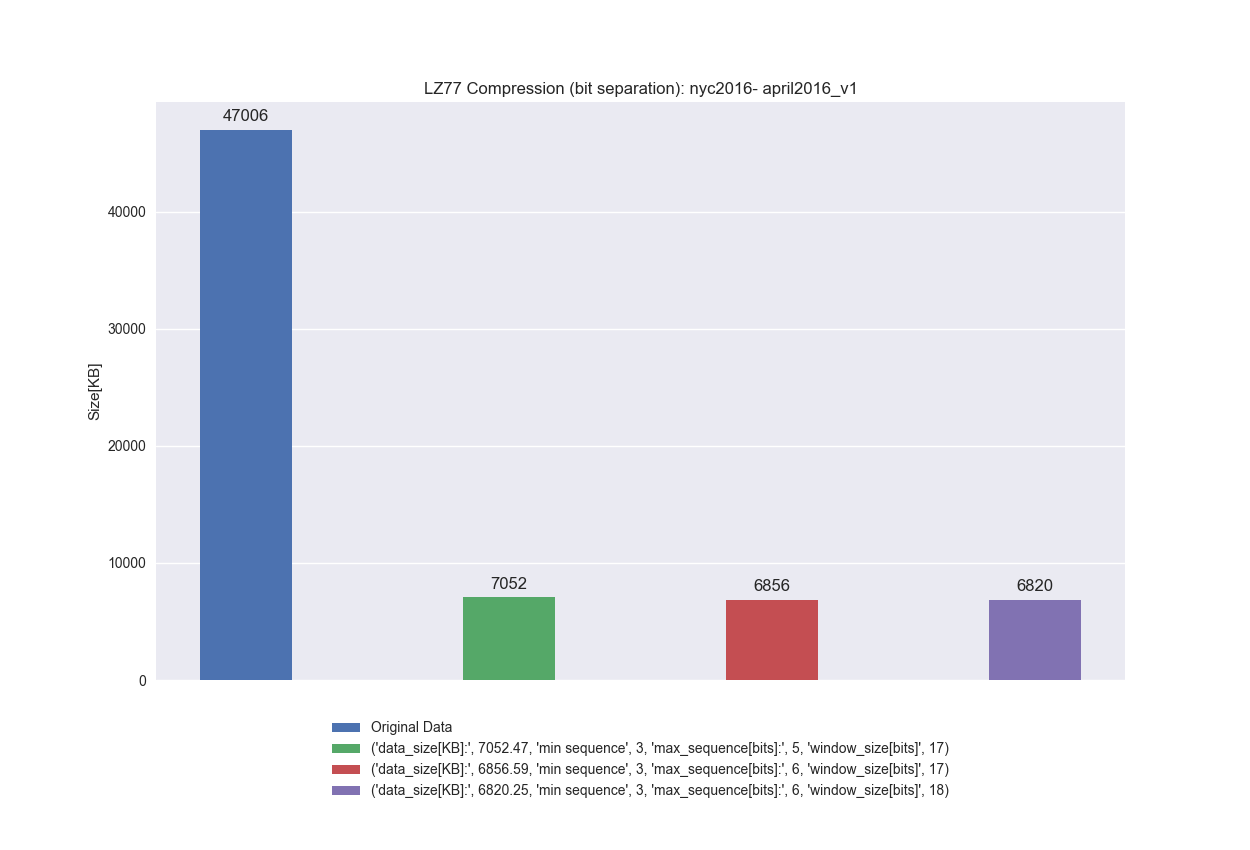
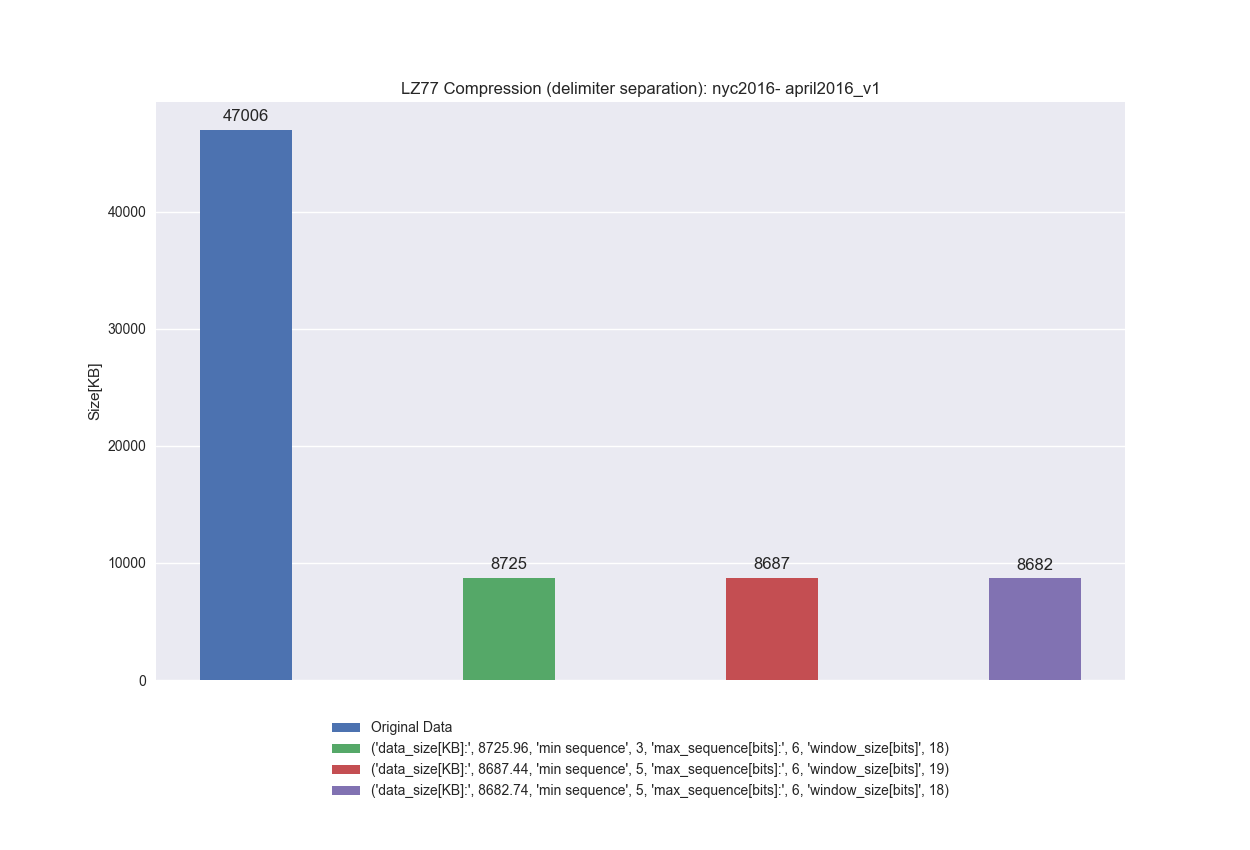

As we can see in case of the second method of **bit separation**:  
We get better Compression Ratio: [1.0, 0.15, 0.15, 0.15]  
The min length character to copy is 3 (the minimum we allow), the max bits to copy is 6(2^6-1+3=67 symbols to copy)  
And we get the best result when the window size is 18 bits(256kB) if we increase we pay in more  the overhead.  
In the 3 method of **delimiter separation**:  
The Compression Ratio: [1.0, 0.19, 0.18, 0.18] 
The min length character to copy is 5, (probably because of the overhead of the special symbol - 8 bits)  
And max sequence bits to copy is 5 (2^6-+5=68) , the optimize window size here 18 bits.  
For this data set the second method is better then the third, means we have a lot of short string to copy that the bit separations give batter result.  
Again we didn't consider here the time simulation , for both cases the window size is extremely high 256KB ,although we get for this parameters the best results this window size will harm the performance of the algorithm.

## Part-III

In this part we show 5 ways of improvement to LZ77 and Huffman algorithms, we will try to decrease the output size and compression ratio by the following methods:  
1) **LZ77 and Huffman** - combine the 2 algorithms together like DEFLATE and GZIP.  
2) **LZ77 (separate: data, control,length,distance) and Huffman** -split the result of the LZ77 to 4 different codes: data, control,length,distance and perform Huffman on each of one of them.  
3) **Separated columns**- perform Huffman and LZ77 on each columns.  
4) **Clustered Huffman** - compares Huffman using machine learnings technique of clustering. (In the Last Part of the report).   
5) **LZ77 (separate Data, control,length,distance)** and Clustered Huffman. (In the Last Part of the report).  


### <font color=blue> First method- LZ77 and hufmman </font>
Like GZIP and DEFLATE algorithms we try to combine Lempel-Ziv compression and Huffman coding together. 

In [ ]:
from huffman_and_lz77_ext_func import LZ77_huffman

for i in range(len(data_file)):
    figure_i=i
    lz77_and_huff_data_control = LZ77_huffman_data_control(data_file[i], train_set_file[i],\
                                "LZ77+Huffman compression (split data control): " + title[i],\
                                 Fast_mode, max_seq_bits[i], window_size_bits_s[i])
    lz77_and_huff_data_control.lz77_and_huffman_compression(figure_i)

#plt.show()

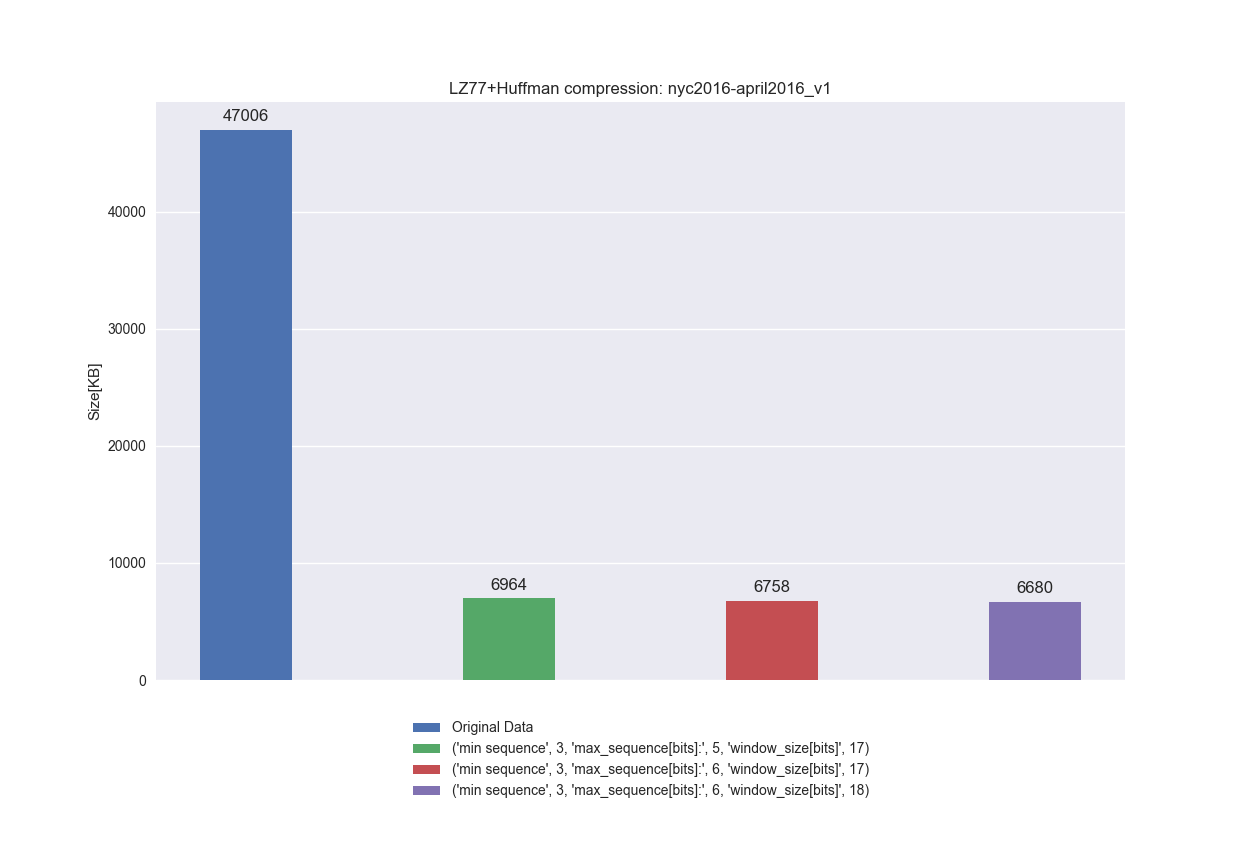

**Compression Ratio**: [1.0, 0.15, 0.14, 0.14]  
As we can see we get batter result by combining LZ77 and Huffman from using simple Huffman algorithm or LZ77 algorithm alone.
But the also in this case improvement is small ,the main reason is the way we implement the LZ77 with the bit separation that cause to each character to grow in one bit .  
The Huffman work on a char so basically we increase a lot of the variance of the data by adding this bit and reduce the effective of the Huffman compression.


### <font color=blue> Second method- LZ77 and Huffman ( separate data ,control,length,offset_high,offset_low)</font>

In the First method we saw that Huffman stage didn't improve a lot the LZ77 algorithms ,  
the reason is the additional bit we add for each character and the Huffman work on every 8 bits(char) so by this method of compressing we increase a lot the variance of the data and harm the effectiveness of Huffman.
Another approach is to split the data ,control,length,offset_high,offset_low to 5 outputs outputs:
* **Data**- we have now char(that will decrease the variance of the data).  
* **Control**- we have '0' or '1'- 0 means pure character and '1' start of [length,distance] pair.  
* **Length**(bit)- maximum sequence to copy.  
* **offset_high **(bit)- maximum window size first 8 higher bits.  
* **offset_low **(bit)- maximum window size lower bits bits.  

In [ ]:
from huffman_and_lz77_data_control_ext_func import LZ77_huffman_data_control
min_seq=[4,5,6] # minimum sequnce to copy
max_seq_bits=[[8,8]] #for fast mode  decide the range values for max_seq bits(length)
window_size_bits_s=[[16,16]]#for fast mode  decide the range values for window_size bits(offset)

for i in range(len(data_file)):
    figure_i=i
    lz77_and_huff_data_control = LZ77_huffman_data_control(data_file[i], train_set_file[i],\
                                "LZ77+Huffman compression (split data control): " + title[i],\
                                 Fast_mode, max_seq_bits[i], window_size_bits_s[i],min_seq[i])
    lz77_and_huff_data_control.lz77_and_huffman_compression(figure_i)

#plt.show()

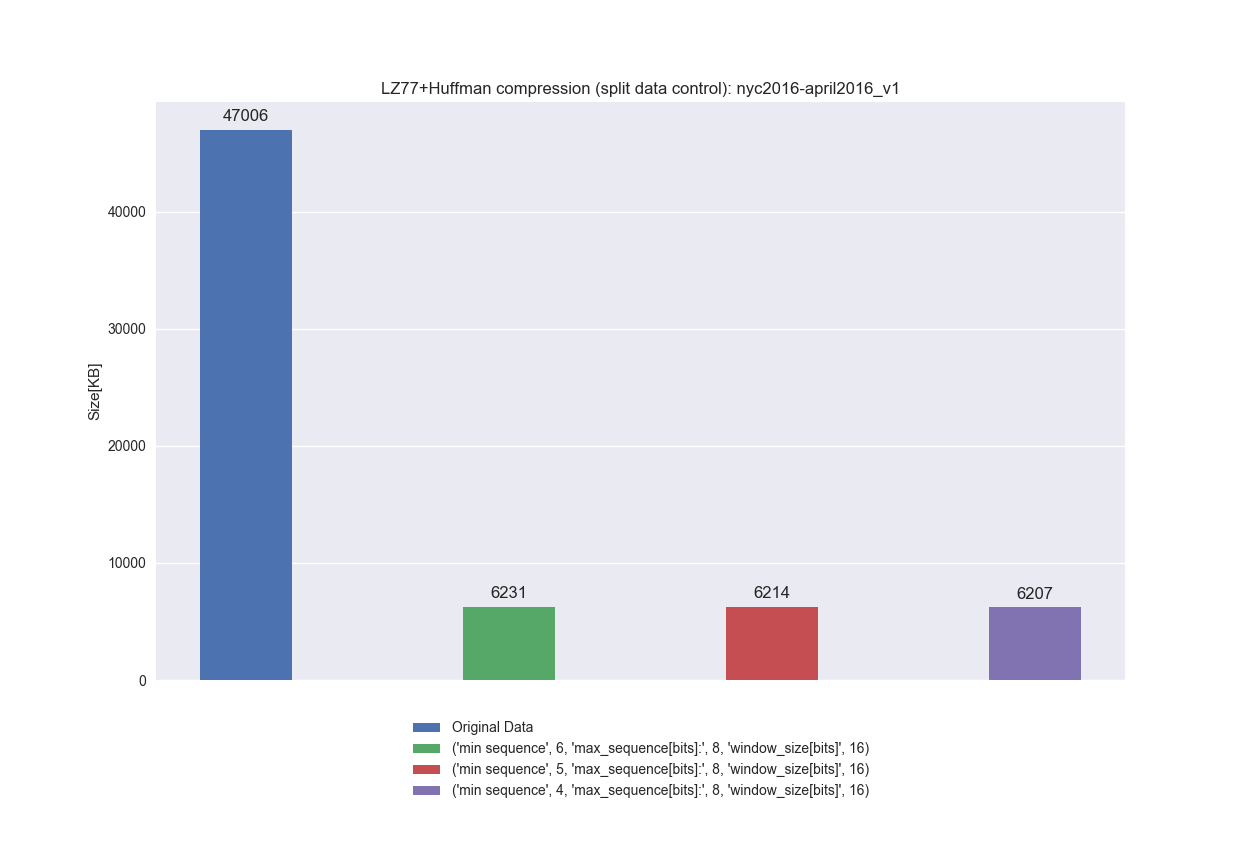

**Compression Ratio**: [1.0, 0.13, 0.13, 0.13].  
Now after we split the data ,control,length,offset_high,offset_low we can  that the Huffman compression in the second phase give batter results.  
Also here the best results we get(after checking variance of inputs in slow mode option) is for window_size=16[bit] (64KB) and max_sequence=8[bit] ,  
the reason again is the Huffman work on char(8 bits) and for this parameters we get that Huffman is the most effective on windows_size and max_sequence.
In this case we see again that we prefer to not maximize the LZ77 compression for getting the best result Instead we need to get the best compression that keep small variance with size bits that divide by char(8 bits) so the Huffman will be more effective. 
Also we get improvement in time simulation because decreasing the windows size bits, and parallelize the Huffman compression.  
In  we get the same conclusion like the last part that we need to find the compression balance between LZ77 to Huffman.


### <font color=blue> Third method-Separation column</font>
Another try is to use the algorithm compression for each column.  
In this case the variance of the data should be much smaller and the effective of both algorithms will be grater, this way of compression should improve our compression ratio.  
In this part we not only split by columns but also special characters that can apear in the data like: floating point '/' or '-' in dates and ':' in times 

In [ ]:
from separate_column_ext_func import separate_columns_compress

equal=[True]

for i in range (len(data_file)):
    figure_i=i
    compress = separate_columns_compress(data_file[i], train_set_file[i], "LZ77+Huffman compression (split columns): " + title[i],
                                    Fast_mode, max_seq_bits[i], window_size_bits_s[i],debug,equal[i])
    compress.separate_columns_compression(figure_i)
#plt.show()

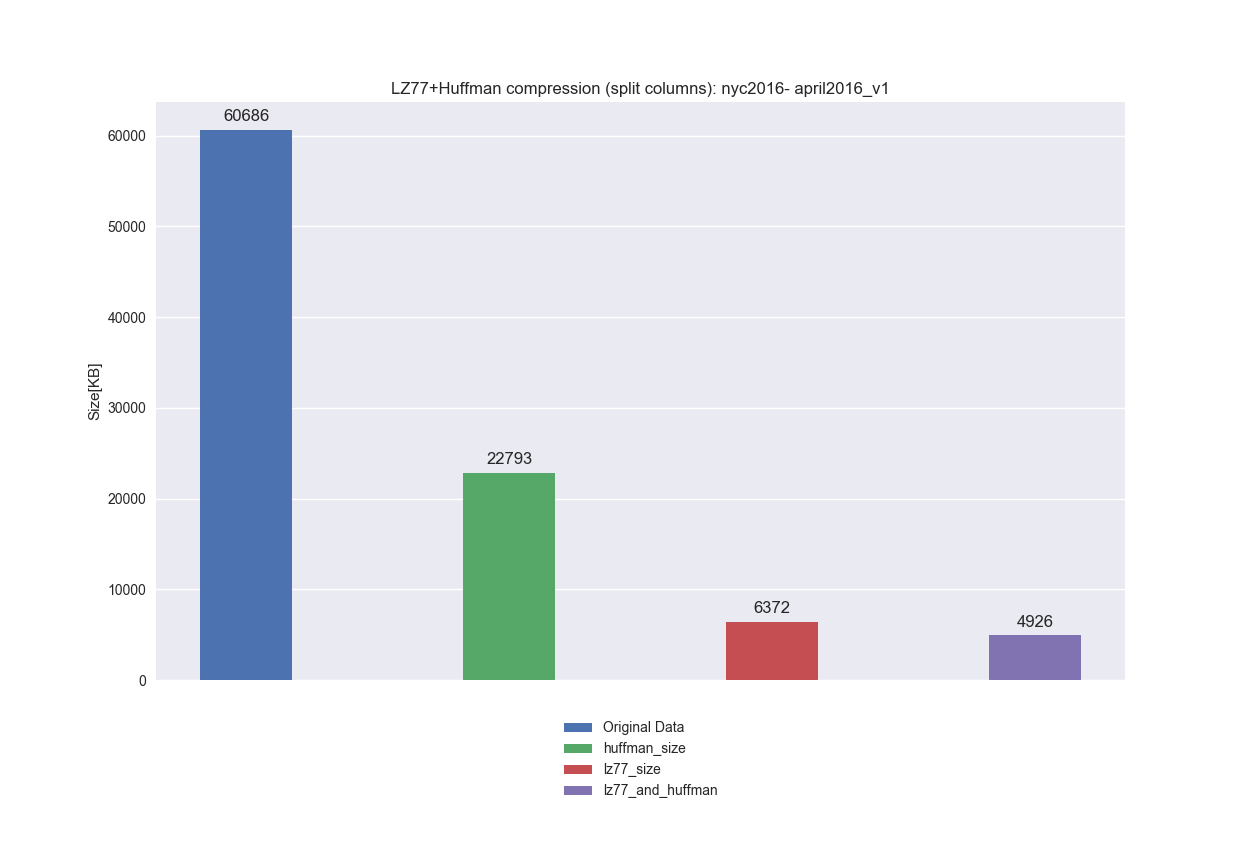

As we expected by separate to column the variance of each column of data is smaller and also the compression ratio  comparing using all data and we get much better result:  
**Huffman**- compression_ratio= 0.38 compare to compression_ratio=0.47 in case of compressing all data.  
**LZ77** - compression_ratio= 0.1 compare to compression_ratio=0.15 in case of compressing all data.  
**LZ77 and Huffman** - compression_ratio= 0.08 compare to compression_ratio=0.136 in case of compressing all data.
Also the simulation run-time for this case can significantly improve if we using parallel computing ,  
the disadvantage for this is that the data should be in fixed template (that every sample have the same field). 
And we saw cases like the data set before that this method can't be used.

## K means (Nadav part)

## to interleave in stage 3

JSON format contains a lot of non semantic information spaces and line breaks suppose to make the data set easier to read by human beings. 
Before applying any fency compression we can easialy reduce data set size by give up the human readablity and trim all the fluffy characters. 
reading the data set and dump it again with python json package reduce the file size from 6149910 Bytes to 4865853 Bytes (0.79%), it becoming a one big line looking like that:
....{"latitudeE7": 404212492, "accuracy": 26, "longitudeE7": -36286189, "timestampMs": "1412114163888"}, {"latitudeE7": 404212787, "accuracy": 21, "longitudeE7": -36285734, "timestampMs": "1412114103956"}....

but the default dump still pad spaces after ':' and ',', so we can do better by drop it too (code below) that output data set file sized 4476978 Bytes (0.72%)

In [ ]:
# mobile location history pre processing v1 for part 3 

MOBILE_LOCATION_HISTORY_REFORMAT_V1_PATH = '../modified_data_sets/mobileLocationHistory102014/location_history_102014_v1.json'

with open(MOBILE_LOCATION_HISTORY_PATH, 'r') as fr:
    raw = json.loads(fr.read())

with open(MOBILE_LOCATION_HISTORY_REFORMAT_V1_PATH, 'w') as outfile:
    json.dump(raw, outfile, separators=(',', ':'))
print 'done processing'

# Summary

In this project we investigated the effectiveness of "lossless" compression algorithms.  
We focused on 2 algorithms: ZL77 and Huffman, and saw the advantages of each one of them: 
LZ77 is batter when there are a lot of sequence repetition and the order of the stream is less random  
On the other hand Huffman strength is when there are a certain symbols with more probability to occur - when the entropy of the system is small.    
In this project we implement both of the algorithms in python, we saw that the decision we choose in the way of implement the algorithm have great effect on the results, as we saw in part 1 for Huffman algorithm,the success of the algorithm depend on the way we generate alphabet input to the Huffman dictionary, or the way we implement the code algorithms like in LZ77 we check 2 methods: separate the pure character and [length, offset] pair by bit or special delimiter each implementation has its advantages and can give different result.
For our data sets we saw that we prefer to copy max [34,67] character using LZ77 that means the bit separation algorithms get the best results because is overhead is smaller. also in this part we saw that are parameters that give the best result not give the best performance time and some time we prefer to get batter simulation time on expense of compression ratio.   
In part 3 we suggest and examine 5 ways to improve the algorithm compression from part 1 and 2:  
The first approach is combine the 2 algorithms together like GZIP and DEFLATE, as we explained above we prefer to use first LZ77 over Huffman because of is in treating dependencies between symbols after using LZ77 we use Huffman code that the symbols are more random. In this solution we notice that over implement of LZ77 in bit separation that give batter result than the data delimiter has huge disadvantage that is output increase the variance of the data(by adding one bit to each character) .  
To overcome on this problem we suggest another solution to split the LZ77 outputs to data,control,length,offset_high and offset_low(distance) parts and perform different Huffman on each one of them, by using this approach we reduce the variance of the output data and increase the effectiveness of the Huffman algorithm. 
Also we reduce a lot the simulation time due to decrease of the window size to(64 KB or 256B) also by splitting to 5 outputs ,  
the Huffman running time improve (reduce the data for each Huffman) in case we using parallel computing.  
In this case we saw that the Huffman is significantly more efficient when the distance(window size) is 16 or 8 and offset is 8 , 
Also not alway using the minimum sequence give the best result sometime we want to save  pointers in replacing more bits in each pointer and reduce the variance of the fields of the pointer.In every parameter we use we always need to find the tuning between the LZ77 and Huffman for getting the best results.
The 3rd approach his also to reduce the variance of data by splitting the data to different columns and different delimiters that can show a repetition of similar values. This method give us the best result so far in case the data is in format of equals column if is not it can ham the compression like we saw in data set 2.
The k-means clusters  
K means cluster with Lempel-Ziv <Nadav>  

